In [1]:
import json
import os

def load_diffusion_data(input_dir="diffusion_data", file_name="train.json"):
    """Load processed diffusion data from the specified JSON file."""
    file_path = os.path.join(input_dir, file_name)
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            try:
                record = json.loads(line.strip())
                data.append(record)
            except json.JSONDecodeError as e:
                print(f"Error decoding line: {str(e)}")
    
    print(f"Loaded {len(data)} records from {file_path}")
    return data


#train_data = load_diffusion_data(file_name="trainv6.json")
test_data = load_diffusion_data(file_name="valv7.json") 
#print(f"First train record: {train_data[0]}")
print(f"First test record: {test_data[0]}")

    
    
import numpy as np

print("Calculating normalization statistics from train_data...")
all_coords_list = [item['X_Y_combined'] for item in test_data]
if not all_coords_list:
    raise ValueError("train_data is empty, cannot calculate normalization stats.")
all_coords_np = np.array(all_coords_list, dtype=np.float32) # Shape: (N_samples, N_POINTS, XY_DIM)
# Handle potential NaNs or Infs if your data might have them
all_coords_np = np.nan_to_num(all_coords_np, nan=0.0, posinf=0.0, neginf=0.0) # Example handling

x_mean = np.mean(all_coords_np[:, :, 0])
x_std = np.std(all_coords_np[:, :, 0])
y_mean = np.mean(all_coords_np[:, :, 1])
y_std = np.std(all_coords_np[:, :, 1])

# Add small epsilon to std dev to avoid division by zero if data is constant
x_std = x_std if x_std > 1e-6 else 1.0
y_std = y_std if y_std > 1e-6 else 1.0

print(f"Normalization Stats: X ~ N({x_mean:.3f}, {x_std:.3f}^2), Y ~ N({y_mean:.3f}, {y_std:.3f}^2)")

train_data = test_data

Loaded 30518 records from diffusion_data/valv7.json
First test record: {'RPN': 'C', 'token_ids': [1, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'X_Y_combined': [[-0.8320537805557251, 0.3649405837059021], [-1.404200553894043, 0.3649405837059021], [1.2733465433120728, 0.3649405837059021], [0.27639350295066833, 0.3649405837059021], [0.15770481526851654, 0.3649405837059021], [0.28379929065704346, 0.3649405837059021], [-0.7955589890480042, 0.3649405837059021], [1.6879225969314575, 0.3649405837059021], [0.7365068793296814, 0.3649405837059021], [-0.8042354583740234, 0.3649405837059021], [0.8534086346626282, 0.3649405837059021], [-1.7193682193756104, 0.3649405837059021], [1.402612566947937, 0.3649405837059021], [-1.2457026243209839, 0.3649405837059021], [-1.2989997863769531, 0.3649405837059021], [0.3934226632118225, 0.3649405837059021], [-0.4810568690299988, 0.3649405837059021], [-0.2329765409231186, 0.3649405837059021], [-1.5189077854156494, 0.3649405837059021], [-1.4036635160446167, 0.364940583705902

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import math
import time
import random
import sys
import os
import matplotlib.pyplot as plt
from IPython import display

# --- Configuration (Using User-Provided Values) ---
# Data Parameters
SEQ_LEN = 20
N_POINTS = 30
XY_DIM = 2
PAD_TOKEN_ID = 0
VOCAB_SIZE = 17

# Model Capacity (Large)
EMBED_DIM = 192
NUM_HEADS = 12
NUM_LAYERS = 8
DIM_FEEDFORWARD = 768
DROPOUT = 0.1

# Diffusion Parameters
NUM_TIMESTEPS = 1000
BETA_START = 0.0001
BETA_END = 0.02
SCHEDULE_TYPE = 'cosine'

# Training Parameters
BATCH_SIZE = 128
VALIDATION_BATCH_SIZE = 256
LEARNING_RATE = 1e-4 # Reset to user's value for this run
EPOCHS = 15
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PATIENCE = 50
BEST_MODEL_PATH = "best_d3pm_pointnet_crossattn.pth" # New path


# --- Helper Functions ---
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

setup_seed(42)

def linear_beta_schedule(timesteps, beta_start=BETA_START, beta_end=BETA_END):
    """Linear schedule from beta_start to beta_end."""
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

def cosine_beta_schedule(timesteps, s=0.008):
    """Cosine schedule."""
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def extract(a, t, x_shape):
    """Extract coefficients at specified timesteps t, reshaping to x_shape."""
    batch_size = t.shape[0]
    out = a.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))


# --- Diffusion Logic ---
class DiscreteDiffusion:
    def __init__(self, num_timesteps=NUM_TIMESTEPS, vocab_size=VOCAB_SIZE, device=DEVICE): # Correct ':'
        self.num_timesteps = num_timesteps
        self.vocab_size = vocab_size
        self.device = device

        if SCHEDULE_TYPE == 'linear': # Correct ':'
            self.betas = linear_beta_schedule(num_timesteps).to(device)
        elif SCHEDULE_TYPE == 'cosine': # Correct ':'
            self.betas = cosine_beta_schedule(num_timesteps).to(device)
        else: # Correct ':'
            raise ValueError(f"Unknown schedule type: {SCHEDULE_TYPE}")

        self.alphas = (1. - self.betas).to(device)
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0).to(device)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0).to(device)

        self.log_q_t_x_t_minus_1 = self._compute_log_q_t_x_t_minus_1()
        self.log_q_t_x_0 = self._compute_log_q_t_x_0()
        self.log_q_t_minus_1_x_t_x_0 = self._compute_log_q_t_minus_1_x_t_x_0()

    def _compute_log_q_t_x_t_minus_1(self): # Correct ':'
        """ Compute log q(x_t | x_{t-1}) """
        log_q = torch.zeros(self.num_timesteps, self.vocab_size, self.vocab_size, device=self.device, dtype=torch.float64)
        eye = torch.eye(self.vocab_size, device=self.device) # Precompute eye
        for t in range(self.num_timesteps): # Correct ':'
            beta_t = self.betas[t]
            diag_indices = torch.arange(self.vocab_size, device=self.device)
            log_q[t, diag_indices, diag_indices] = torch.log(1.0 - beta_t + beta_t / self.vocab_size)
            off_diag_val = torch.log(beta_t / self.vocab_size)
            log_q[t] = log_q[t] + off_diag_val * (1.0 - eye)
        return log_q.float()

    def _compute_log_q_t_x_0(self): # Correct ':'
        """ Compute log q(x_t | x_0) """
        log_q = torch.zeros(self.num_timesteps, self.vocab_size, self.vocab_size, device=self.device, dtype=torch.float64)
        eye = torch.eye(self.vocab_size, device=self.device) # Precompute eye
        for t in range(self.num_timesteps): # Correct ':'
            alpha_bar_t = self.alphas_cumprod[t]
            diag_indices = torch.arange(self.vocab_size, device=self.device)
            log_q[t, diag_indices, diag_indices] = torch.log(alpha_bar_t + (1.0 - alpha_bar_t) / self.vocab_size)
            off_diag_val = torch.log((1.0 - alpha_bar_t) / self.vocab_size)
            log_q[t] = log_q[t] + off_diag_val * (1.0 - eye)
        return log_q.float()

    def _compute_log_q_t_minus_1_x_t_x_0(self): # Correct ':'
        """ Compute log q(x_{t-1} | x_t, x_0) """
        log_q_posterior = torch.zeros(self.num_timesteps, self.vocab_size, self.vocab_size, self.vocab_size, device=self.device, dtype=torch.float64)
        log_q_t_x_t_minus_1_64 = self.log_q_t_x_t_minus_1.double()
        log_q_t_x_0_64 = self.log_q_t_x_0.double()
        for t in range(1, self.num_timesteps): # Correct ':'
            log_q_t_given_t_minus_1 = log_q_t_x_t_minus_1_64[t]
            log_q_t_minus_1_given_0 = log_q_t_x_0_64[t-1]
            log_q_posterior[t] = log_q_t_given_t_minus_1.unsqueeze(1) + log_q_t_minus_1_given_0.unsqueeze(0)
        log_denominator = torch.logsumexp(log_q_posterior, dim=-1, keepdim=True)
        log_denominator = torch.where(torch.isinf(log_denominator), torch.zeros_like(log_denominator), log_denominator)
        log_q_posterior = log_q_posterior - log_denominator
        log_q_posterior = torch.clamp(log_q_posterior, -100.0, 0.0)
        return log_q_posterior.float()

    def q_sample(self, x_start, t): # Correct ':'
        """ Sample x_t given x_0 and t """
        batch_size, seq_len = x_start.shape
        log_q_t_x_0_for_batch_t = self.log_q_t_x_0[t]
        x_start_expanded = x_start.unsqueeze(-1)
        log_q_t_x_0_expanded = log_q_t_x_0_for_batch_t.unsqueeze(1).expand(-1, seq_len, -1, -1)
        x_start_indices = x_start_expanded.unsqueeze(-1).expand(-1, -1, self.vocab_size, -1)
        x_start_indices = torch.clamp(x_start_indices, 0, self.vocab_size - 1)
        log_probs = torch.gather(log_q_t_x_0_expanded, dim=3, index=x_start_indices).squeeze(-1)
        gumbel_noise = torch.rand_like(log_probs)
        gumbel_noise = -torch.log(-torch.log(gumbel_noise.clamp(min=1e-9)) + 1e-9)
        x_t = torch.argmax(log_probs + gumbel_noise, dim=-1)
        return x_t.long()

    def q_posterior_log_probs(self, x_0, x_t, t): # Correct ':'
        """ Compute log q(x_{t-1} | x_t, x_0) """
        batch_size, seq_len = x_0.shape
        log_q_posterior_t = self.log_q_t_minus_1_x_t_x_0[t]
        log_q_posterior_t = log_q_posterior_t.unsqueeze(1).expand(-1, seq_len, -1, -1, -1)
        x_t_idx = x_t.view(batch_size, seq_len, 1, 1, 1).expand(-1, -1, -1, self.vocab_size, self.vocab_size)
        x_t_idx = torch.clamp(x_t_idx, 0, self.vocab_size - 1)
        log_q_posterior_t_i = torch.gather(log_q_posterior_t, dim=2, index=x_t_idx).squeeze(2)
        x_0_idx = x_0.view(batch_size, seq_len, 1, 1).expand(-1, -1, -1, self.vocab_size)
        x_0_idx = torch.clamp(x_0_idx, 0, self.vocab_size - 1)
        log_q_posterior_t_i_j = torch.gather(log_q_posterior_t_i, dim=2, index=x_0_idx).squeeze(2)
        return log_q_posterior_t_i_j

    def p_log_probs(self, model, x_t, t, condition): # Correct ':'
        """ Compute log p_theta(x_0 | x_t, t, condition) """
        log_pred_x0 = model(x_t, t, condition)
        return F.log_softmax(log_pred_x0, dim=-1)

    def p_sample(self, model, x_t, t, condition): # Correct ':'
        """ Sample x_{t-1} from p_theta(x_{t-1} | x_t, t, condition) """
        batch_size, seq_len = x_t.shape
        device = x_t.device
        log_pred_x0 = self.p_log_probs(model, x_t, t, condition)
        log_q_posterior_t = self.log_q_t_minus_1_x_t_x_0[t]
        log_q_posterior_t = log_q_posterior_t.unsqueeze(1).expand(-1, seq_len, -1, -1, -1)
        x_t_idx = x_t.view(batch_size, seq_len, 1, 1, 1).expand(-1, -1, -1, self.vocab_size, self.vocab_size)
        x_t_idx = torch.clamp(x_t_idx, 0, self.vocab_size - 1)
        log_q_posterior_t_i = torch.gather(log_q_posterior_t, dim=2, index=x_t_idx).squeeze(2)
        log_pred_x0_expanded = log_pred_x0.unsqueeze(-1)
        log_sum_terms = log_q_posterior_t_i + log_pred_x0_expanded
        log_p_t_minus_1_given_t = torch.logsumexp(log_sum_terms, dim=2)
        log_p_t_minus_1_given_t = F.log_softmax(log_p_t_minus_1_given_t, dim=-1)
        gumbel_noise = torch.rand_like(log_p_t_minus_1_given_t)
        gumbel_noise = -torch.log(-torch.log(gumbel_noise.clamp(min=1e-9)) + 1e-9)
        x_t_minus_1 = torch.argmax(log_p_t_minus_1_given_t + gumbel_noise, dim=-1)
        return x_t_minus_1.long()

    @torch.no_grad()
    def sample(self, model, condition, shape): # Correct ':'
        """ Generate samples from the model """
        batch_size, seq_len = shape
        device = self.device
        model.eval() # Ensure model is in eval mode for sampling
        x_t = torch.randint(1, self.vocab_size, size=shape, device=device).long() # Avoid sampling PAD initially if possible

        for t in reversed(range(0, self.num_timesteps)): # Correct ':'
            print(f"\rSampling timestep {t+1}/{self.num_timesteps}   ", end="")
            sys.stdout.flush()
            t_tensor = torch.full((batch_size,), t, device=device, dtype=torch.long)
            if t > 0: # Correct ':'
                 x_t = self.p_sample(model, x_t, t_tensor, condition)
            else: # Correct ':'
                 # At t=0, use the model's prediction of x_0 directly
                 log_pred_x0 = self.p_log_probs(model, x_t, t_tensor, condition)
                 # Sample x_0 from the final prediction
                 gumbel_noise = torch.rand_like(log_pred_x0)
                 gumbel_noise = -torch.log(-torch.log(gumbel_noise.clamp(min=1e-9)) + 1e-9)
                 x_t = torch.argmax(log_pred_x0 + gumbel_noise, dim=-1).long()

        print("\nSampling complete.")
        model.train() # Set back to train mode after sampling
        return x_t

    def compute_loss(self, model, x_start, condition, pad_token_id=PAD_TOKEN_ID): # Correct ':'
        """ Compute the training loss """
        batch_size, seq_len = x_start.shape
        device = x_start.device
        t = torch.randint(0, self.num_timesteps, (batch_size,), device=device).long()
        x_t = self.q_sample(x_start, t)
        log_pred_x0 = self.p_log_probs(model, x_t, t, condition)
        # Calculate NLL loss
        loss = F.nll_loss(log_pred_x0.permute(0, 2, 1), # Needs [B, K, S] for nll_loss
                          x_start,
                          ignore_index=pad_token_id,
                          reduction='none') # [B, S]
        # Average loss over non-padding tokens
        mask = (x_start != pad_token_id).float()
        loss = (loss * mask).sum() / mask.sum().clamp(min=1) # Average over non-pad tokens per batch
        return loss


# --- Model Architecture Components ---
class PositionalEncoding(nn.Module): # Correct ':'
    def __init__(self, d_model, dropout=0.1, max_len=5000): # Correct ':'
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1) # Shape: [max_len, 1, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x): # Correct ':'
        # Input x expected shape: [seq_len, batch_size, embedding_dim]
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TimestepEmbedding(nn.Module): # Correct ':'
    def __init__(self, dim, max_period=10000): # Correct ':'
        super().__init__()
        self.dim = dim
        self.max_period = max_period

    def forward(self, t): # Correct ':'
        device = t.device
        half = self.dim // 2
        freqs = torch.exp(-math.log(self.max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half).to(device)
        args = t[:, None].float() * freqs[None, :]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if self.dim % 2: # Correct ':' # Handle odd embedding dim
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

# --- PointNet-Style Encoder for Conditioning ---
class PointCloudEncoder(nn.Module): # Correct ':'
    def __init__(self, input_dim=XY_DIM, embed_dim=EMBED_DIM): # Correct ':'
        super().__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim

        # Shared MLPs implemented using Conv1d
        self.mlp1 = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=1),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        # Final MLP after max pooling
        self.mlp2 = nn.Sequential(
            nn.Linear(256, embed_dim * 2),
            nn.ReLU(),
            nn.Linear(embed_dim * 2, embed_dim)
        )

    def forward(self, point_cloud): # Correct ':'
        # point_cloud shape: (B, N_POINTS, XY_DIM)
        x = point_cloud.permute(0, 2, 1) # (B, XY_DIM, N_POINTS)
        point_features = self.mlp1(x) # (B, 256, N_POINTS)
        global_feature, _ = torch.max(point_features, dim=2) # (B, 256)
        condition_embedding = self.mlp2(global_feature) # (B, embed_dim)
        return condition_embedding

# --- Modified ConditionalD3PMTransformer ---
class ConditionalD3PMTransformer(nn.Module): # Correct ':'
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, dim_feedforward,
                 seq_len, condition_dim, # condition_dim is XY_DIM for PointCloudEncoder input
                 num_timesteps, dropout=0.1): # Correct ':'
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.seq_len = seq_len
        self.num_layers = num_layers

        # Embeddings
        self.token_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_TOKEN_ID)
        self.positional_encoding = PositionalEncoding(embed_dim, dropout, max_len=seq_len + 1)
        self.timestep_embedding = nn.Sequential(
            TimestepEmbedding(embed_dim),
            nn.Linear(embed_dim, embed_dim), nn.SiLU(), nn.Linear(embed_dim, embed_dim)
        )
        # Use PointCloudEncoder for condition
        self.condition_encoder = PointCloudEncoder(input_dim=XY_DIM, embed_dim=embed_dim)

        # Optional: Condition Dropout Probability
        self.condition_dropout_prob = 0.1 # Set to 0 to disable

        # Manual Transformer Block Components
        self.encoder_self_attn_layers = nn.ModuleList()
        self.encoder_cross_attn_layers = nn.ModuleList()
        self.encoder_ffn_layers = nn.ModuleList()
        self.encoder_norm1_layers = nn.ModuleList()
        self.encoder_norm2_layers = nn.ModuleList()
        self.encoder_norm3_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        for _ in range(num_layers): # Correct ':'
            self.encoder_self_attn_layers.append(nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True))
            self.encoder_cross_attn_layers.append(nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True))
            self.encoder_ffn_layers.append(nn.Sequential(
                nn.Linear(embed_dim, dim_feedforward), nn.GELU(), nn.Dropout(dropout),
                nn.Linear(dim_feedforward, embed_dim)
            ))
            self.encoder_norm1_layers.append(nn.LayerNorm(embed_dim))
            self.encoder_norm2_layers.append(nn.LayerNorm(embed_dim))
            self.encoder_norm3_layers.append(nn.LayerNorm(embed_dim))
            self.dropout_layers.append(nn.Dropout(dropout))

        self.output_layer = nn.Linear(embed_dim, vocab_size)
        self.init_weights()

    def init_weights(self): # Correct ':'
        initrange = 0.1
        self.token_embedding.weight.data.uniform_(-initrange, initrange)
        if self.token_embedding.padding_idx is not None: # Correct ':'
             self.token_embedding.weight.data[self.token_embedding.padding_idx].zero_()
        self.output_layer.bias.data.zero_()
        self.output_layer.weight.data.uniform_(-initrange, initrange)
        # Init PointCloudEncoder layers
        for layer in self.condition_encoder.modules(): # Correct ':'
             if isinstance(layer, (nn.Conv1d, nn.Linear)): # Correct ':'
                 layer.weight.data.normal_(mean=0.0, std=0.02)
                 if layer.bias is not None: # Correct ':'
                     layer.bias.data.zero_()
             elif isinstance(layer, nn.BatchNorm1d): # Correct ':'
                 layer.weight.data.fill_(1.0)
                 layer.bias.data.zero_()

    def forward(self, x, t, condition): # Correct ':'
        # CONDITION INPUT SHAPE CHANGE: Expects (B, N_POINTS, XY_DIM)
        batch_size, seq_len = x.shape
        device = x.device

        # 1. Embeddings
        token_emb = self.token_embedding(x) * math.sqrt(self.embed_dim)
        token_emb_permuted = token_emb.transpose(0, 1)
        pos_emb_permuted = self.positional_encoding(token_emb_permuted)
        pos_emb = pos_emb_permuted.transpose(0, 1)
        time_emb = self.timestep_embedding(t)
        time_emb = time_emb.unsqueeze(1).expand(-1, seq_len, -1)

        # 2. Condition Embedding
        cond_emb_proj = self.condition_encoder(condition)

        # Optional: Condition Dropout
        if self.training and self.condition_dropout_prob > 0: # Correct ':'
            mask = (torch.rand(cond_emb_proj.shape[0], 1, device=cond_emb_proj.device) > self.condition_dropout_prob).float()
            cond_emb_proj = cond_emb_proj * mask

        cond_kv = cond_emb_proj.unsqueeze(1)

        # 3. Initial sequence representation
        current_input = pos_emb + time_emb

        # 4. Padding mask
        padding_mask = (x == PAD_TOKEN_ID)

        # --- Transformer Blocks Loop ---
        for i in range(self.num_layers): # Correct ':'
            # Self-Attention
            sa_norm_input = self.encoder_norm1_layers[i](current_input)
            sa_output, _ = self.encoder_self_attn_layers[i](query=sa_norm_input, key=sa_norm_input, value=sa_norm_input, key_padding_mask=padding_mask)
            x = current_input + self.dropout_layers[i](sa_output)
            # Cross-Attention
            ca_norm_input = self.encoder_norm3_layers[i](x)
            ca_output, _ = self.encoder_cross_attn_layers[i](query=ca_norm_input, key=cond_kv, value=cond_kv)
            x = x + self.dropout_layers[i](ca_output)
            # Feed-Forward
            ffn_norm_input = self.encoder_norm2_layers[i](x)
            ffn_output = self.encoder_ffn_layers[i](ffn_norm_input)
            x = x + ffn_output
            current_input = x
        # --- End Loop ---

        transformer_output = current_input
        output_logits = self.output_layer(transformer_output)
        return output_logits


# --- Dataset (MODIFIED) ---
class SymbolicRegressionDataset(Dataset): # Correct ':'
    def __init__(self, data, x_mean=0.0, x_std=1.0, y_mean=0.0, y_std=1.0): # Correct ':'
        self.data = data
        self.x_mean, self.x_std = x_mean, x_std
        self.y_mean, self.y_std = y_mean, y_std
        self.processed_data = []
        for item in data: # Correct ':'
             token_ids = np.array(item['token_ids'], dtype=np.int64)
             if np.any(token_ids >= VOCAB_SIZE): # Correct ':'
                 token_ids = np.clip(token_ids, 0, VOCAB_SIZE - 1)

             xy_coords = np.array(item['X_Y_combined'], dtype=np.float32)
             # Apply Normalization
             xy_coords[:, 0] = (xy_coords[:, 0] - self.x_mean) / (self.x_std + 1e-8)
             xy_coords[:, 1] = (xy_coords[:, 1] - self.y_mean) / (self.y_std + 1e-8)

             # Store unflattened tensor
             condition_tensor = torch.from_numpy(xy_coords)

             self.processed_data.append({
                 'token_ids': torch.from_numpy(token_ids),
                 'condition': condition_tensor
             })

    def __len__(self): # Correct ':'
        return len(self.processed_data)

    def __getitem__(self, idx): # Correct ':'
        return self.processed_data[idx]


# --- Evaluation Function ---
@torch.no_grad()
def evaluate(model, diffusion, val_loader, device): # Correct ':'
    model.eval()
    total_val_loss = 0.0
    num_batches = 0
    for batch in val_loader: # Correct ':'
        x_start = batch['token_ids'].to(device)
        condition = batch['condition'].to(device) # Shape (B, N_POINTS, XY_DIM)
        if x_start.max() >= VOCAB_SIZE or x_start.min() < 0: # Correct ':'
             print(f"\nWarning: Invalid token ID in validation batch. Skipping.")
             continue
        loss = diffusion.compute_loss(model, x_start, condition, pad_token_id=PAD_TOKEN_ID)
        if not torch.isnan(loss): # Correct ':'
             total_val_loss += loss.item()
             num_batches += 1
        else: # Correct ':'
            print("\nWarning: NaN loss encountered during validation. Skipping batch.")

    model.train()
    if num_batches == 0: # Correct ':'
        print("\nWarning: No valid batches processed during evaluation.")
        return float('inf')
    return total_val_loss / num_batches


# --- Training Function ---
def train(train_data, test_data): # Correct ':'
    print(f"Using device: {DEVICE}")
    print(f"Training data size: {len(train_data)}")
    print(f"Validation (test) data size: {len(test_data)}")

    if not train_data: # Correct ':'
        raise ValueError("train_data list is empty.")
    perform_validation = bool(test_data)
    if not perform_validation: # Correct ':'
        print("Warning: test_data is empty. Skipping validation.")

    # Calculate Normalization Stats
    print("Calculating normalization statistics from train_data...")
    all_coords_list = [item['X_Y_combined'] for item in train_data]
    if not all_coords_list: # Correct ':'
        raise ValueError("train_data is empty, cannot calculate normalization stats.")
    all_coords_np = np.array(all_coords_list, dtype=np.float32)
    all_coords_np = np.nan_to_num(all_coords_np, nan=0.0, posinf=0.0, neginf=0.0)
    x_mean = np.mean(all_coords_np[:, :, 0]); x_std = np.std(all_coords_np[:, :, 0])
    y_mean = np.mean(all_coords_np[:, :, 1]); y_std = np.std(all_coords_np[:, :, 1])
    x_std = x_std if x_std > 1e-6 else 1.0; y_std = y_std if y_std > 1e-6 else 1.0
    print(f"Normalization Stats: X ~ N({x_mean:.3f}, {x_std:.3f}^2), Y ~ N({y_mean:.3f}, {y_std:.3f}^2)")

    # Create Datasets
    train_dataset = SymbolicRegressionDataset(train_data, x_mean, x_std, y_mean, y_std)
    val_loader = None
    if perform_validation: # Correct ':'
        val_dataset = SymbolicRegressionDataset(test_data, x_mean, x_std, y_mean, y_std)
        val_loader = DataLoader(val_dataset, batch_size=VALIDATION_BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True if DEVICE == "cuda" else False)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True if DEVICE == "cuda" else False)

    # Initialize Model
    model = ConditionalD3PMTransformer(
        vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, num_heads=NUM_HEADS, num_layers=NUM_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD, seq_len=SEQ_LEN,
        condition_dim=XY_DIM, # Pass XY_DIM
        num_timesteps=NUM_TIMESTEPS, dropout=DROPOUT
    ).to(DEVICE)

    diffusion = DiscreteDiffusion(num_timesteps=NUM_TIMESTEPS, vocab_size=VOCAB_SIZE, device=DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=max(1, PATIENCE // 2), verbose=True)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    if perform_validation: # Correct ':'
        print(f"Early stopping patience: {PATIENCE}")
        print(f"Best model will be saved to: {BEST_MODEL_PATH}")

    best_val_loss = float('inf'); epochs_no_improve = 0
    epochs_plotted = []; train_losses = []; val_losses = []

    # --- Training Loop ---
    for epoch in range(EPOCHS): # Correct ':'
        model.train()
        total_train_loss = 0.0
        start_time = time.time()
        processed_batches = 0

        for i, batch in enumerate(train_loader): # Correct ':'
            optimizer.zero_grad()
            x_start = batch['token_ids'].to(DEVICE)
            condition = batch['condition'].to(DEVICE) # Shape (B, N_POINTS, XY_DIM)

            if x_start.max() >= VOCAB_SIZE or x_start.min() < 0: # Correct ':'
                 print(f"\nWarning: Invalid token ID in train batch. Skipping.")
                 continue

            loss = diffusion.compute_loss(model, x_start, condition, pad_token_id=PAD_TOKEN_ID)

            if torch.isnan(loss): # Correct ':'
                print(f"\nWarning: NaN loss detected during training. Skipping batch.")
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_train_loss += loss.item()
            processed_batches += 1

            print(f"\rEpoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}   ", end="")
            sys.stdout.flush()

        # --- End of Epoch ---
        avg_train_loss = total_train_loss / processed_batches if processed_batches > 0 else 0
        epoch_time = time.time() - start_time

        # Validation Step
        avg_val_loss = float('inf')
        if perform_validation and val_loader: # Correct ':'
            print(f"\nEpoch [{epoch+1}/{EPOCHS}] completed in {epoch_time:.2f}s. Avg Train Loss: {avg_train_loss:.4f}. Evaluating...", end="")
            sys.stdout.flush()
            avg_val_loss = evaluate(model, diffusion, val_loader, DEVICE)
            print(f" Avg Val Loss: {avg_val_loss:.4f}")
            scheduler.step(avg_val_loss)
        else: # Correct ':'
             print(f"\nEpoch [{epoch+1}/{EPOCHS}] completed in {epoch_time:.2f}s. Avg Train Loss: {avg_train_loss:.4f}. (Validation Skipped)")

        # Store losses for plotting
        epochs_plotted.append(epoch + 1)
        train_losses.append(avg_train_loss)
        if perform_validation: # Correct ':'
             val_losses.append(avg_val_loss)

        # Live Plotting
        try: # Correct ':'
            display.clear_output(wait=True)
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.plot(epochs_plotted, train_losses, 'bo-', label='Training Loss')
            if val_losses: # Correct ':'
                ax.plot(epochs_plotted, val_losses, 'ro-', label='Validation Loss')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.set_title('Training and Validation Loss Over Epochs')
            ax.grid(True)
            ax.legend()
            if max(train_losses, default=0) > 5 * min(train_losses, default=1): # Correct ':'
                 ax.set_yscale('log')
            display.display(fig)
            plt.close(fig)
        except Exception as e: # Correct ':'
            print(f"\nError during plotting: {e}")

        # Early Stopping Check
        if perform_validation: # Correct ':'
            if avg_val_loss < best_val_loss: # Correct ':'
                print(f"Validation loss improved ({best_val_loss:.4f} --> {avg_val_loss:.4f}). Saving model...")
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), BEST_MODEL_PATH)
                epochs_no_improve = 0
            else: # Correct ':'
                epochs_no_improve += 1
                print(f"Validation loss did not improve from {best_val_loss:.4f}. Patience: {epochs_no_improve}/{PATIENCE}")
                if epochs_no_improve >= PATIENCE: # Correct ':'
                    print(f"Early stopping triggered after {epoch + 1} epochs.")
                    break

    # End of Training Loop
    print("Training finished.")
    if perform_validation and os.path.exists(BEST_MODEL_PATH): # Correct ':'
        print(f"Loading best model weights from {BEST_MODEL_PATH} (Val Loss: {best_val_loss:.4f})")
        model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=DEVICE))
    elif perform_validation: # Correct ':'
        print("Warning: Best model path not found, but validation was performed. Returning model from last epoch.")
    else: # Correct ':'
        print("Validation was not performed. Returning model from last epoch.")
    return model


# %% [markdown]
# **Run Training**
# Make sure `train_data` and `test_data` are loaded in your notebook environment before executing the cell below.

# %%
# === EXECUTION ===
if 'train_data' not in locals(): # Correct ':'
     print("ERROR: 'train_data' is not defined.")
     print("Creating minimal dummy data for structure testing ONLY.")
     train_data = []
     def generate_dummy_item(seq_len=SEQ_LEN, n_points=N_POINTS, vocab_size=VOCAB_SIZE): # Correct ':'
         tokens = np.random.randint(1, vocab_size, size=seq_len); pad_len = random.randint(0, seq_len//2);
         if pad_len > 0: # Correct ':'
             tokens[-pad_len:] = PAD_TOKEN_ID
         tokens = np.clip(tokens, 0, vocab_size - 1); xy = np.random.rand(n_points, XY_DIM) * 10 - 5
         xy = xy.reshape(n_points, XY_DIM) # Ensure shape
         return {'token_ids': tokens, 'X_Y_combined': xy}
     train_data = [generate_dummy_item() for _ in range(BATCH_SIZE * 4)]
     test_data = [generate_dummy_item() for _ in range(VALIDATION_BATCH_SIZE * 2)]
     # test_data = [] # To disable validation


In [3]:
# %% [markdown]
# # Load Trained Model Weights (PointNet Encoder + Cross-Attention)
#
# This cell loads the weights saved from the training run that used:
# - PointNet-Style Encoder for condition processing.
# - Cross-Attention conditioning.
# - Increased model capacity.
#
# Ensure the correct model architecture definition and hyperparameters are used.

# %%
import torch
import torch.nn as nn
import torch.nn.functional as F # Needed for model definition potentially
import os
import math # Needed for sqrt in model forward
import numpy as np # May be needed if helper classes use it

# --- Configuration (MUST match the training run that saved the file!) ---
# Data Parameters
SEQ_LEN = 12
N_POINTS = 30
XY_DIM = 2
PAD_TOKEN_ID = 0
VOCAB_SIZE = 17

# Model Capacity (Large - As used when saving)
EMBED_DIM = 192
NUM_HEADS = 12
NUM_LAYERS = 8
DIM_FEEDFORWARD = 768
DROPOUT = 0.1

# Diffusion Parameters (NUM_TIMESTEPS needed for model init)
NUM_TIMESTEPS = 1000 # Or whatever was used

# Training Parameters (Device needed)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# --- IMPORTANT: Update this path if it's different ---
MODEL_TO_LOAD_PATH = "best_d3pm_pointnet_crossattn.pth" # The specific file

# --- Helper Classes (Need definitions available) ---
# Make sure these are defined exactly as they were during training for the saved model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1) # Shape: [max_len, 1, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Input x expected shape: [seq_len, batch_size, embedding_dim]
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TimestepEmbedding(nn.Module):
    def __init__(self, dim, max_period=10000):
        super().__init__()
        self.dim = dim
        self.max_period = max_period

    def forward(self, t):
        device = t.device
        half = self.dim // 2
        freqs = torch.exp(-math.log(self.max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half).to(device)
        args = t[:, None].float() * freqs[None, :]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if self.dim % 2: # Handle odd embedding dim
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

class PointCloudEncoder(nn.Module):
    def __init__(self, input_dim=XY_DIM, embed_dim=EMBED_DIM):
        super().__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.mlp1 = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=1), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=1), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=1), nn.BatchNorm1d(256), nn.ReLU()
        )
        self.mlp2 = nn.Sequential(
            nn.Linear(256, embed_dim * 2), nn.ReLU(),
            nn.Linear(embed_dim * 2, embed_dim)
        )
    def forward(self, point_cloud):
        x = point_cloud.permute(0, 2, 1)
        point_features = self.mlp1(x)
        global_feature, _ = torch.max(point_features, dim=2)
        condition_embedding = self.mlp2(global_feature)
        return condition_embedding

# --- Model Architecture Definition (PointNet Encoder + Cross-Attention Version) ---
class ConditionalD3PMTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, dim_feedforward,
                 seq_len, condition_dim, # Note: condition_dim is XY_DIM here
                 num_timesteps, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size; self.embed_dim = embed_dim; self.seq_len = seq_len
        self.num_layers = num_layers

        self.token_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_TOKEN_ID)
        self.positional_encoding = PositionalEncoding(embed_dim, dropout, max_len=seq_len + 1)
        self.timestep_embedding = nn.Sequential(
            TimestepEmbedding(embed_dim),
            nn.Linear(embed_dim, embed_dim), nn.SiLU(), nn.Linear(embed_dim, embed_dim)
        )
        # Use PointCloudEncoder
        self.condition_encoder = PointCloudEncoder(input_dim=condition_dim, embed_dim=embed_dim)
        self.condition_dropout_prob = 0.1 # Match training setting (or set to 0)

        # Manual Transformer Block Components
        self.encoder_self_attn_layers = nn.ModuleList()
        self.encoder_cross_attn_layers = nn.ModuleList()
        self.encoder_ffn_layers = nn.ModuleList()
        self.encoder_norm1_layers = nn.ModuleList()
        self.encoder_norm2_layers = nn.ModuleList()
        self.encoder_norm3_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        for _ in range(num_layers):
            self.encoder_self_attn_layers.append(nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True))
            self.encoder_cross_attn_layers.append(nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True))
            self.encoder_ffn_layers.append(nn.Sequential(
                nn.Linear(embed_dim, dim_feedforward), nn.GELU(), nn.Dropout(dropout),
                nn.Linear(dim_feedforward, embed_dim)
            ))
            self.encoder_norm1_layers.append(nn.LayerNorm(embed_dim))
            self.encoder_norm2_layers.append(nn.LayerNorm(embed_dim))
            self.encoder_norm3_layers.append(nn.LayerNorm(embed_dim))
            self.dropout_layers.append(nn.Dropout(dropout))

        self.output_layer = nn.Linear(embed_dim, vocab_size)
        self.init_weights()

    def init_weights(self): # Correct ':'
        initrange = 0.1
        self.token_embedding.weight.data.uniform_(-initrange, initrange)
        if self.token_embedding.padding_idx is not None: # Correct ':'
            self.token_embedding.weight.data[self.token_embedding.padding_idx].zero_()
        self.output_layer.bias.data.zero_()
        self.output_layer.weight.data.uniform_(-initrange, initrange)

        # --- Corrected Initialization for PointCloudEncoder ---
        print("Initializing PointCloudEncoder weights...") # Added print for debugging
        for module in self.condition_encoder.modules(): # Iterate through all modules
            # Check if the module is specifically Conv1d or Linear
            if isinstance(module, (nn.Conv1d, nn.Linear)): # Correct ':'
                print(f"  Initializing {module.__class__.__name__}...") # Debug print
                module.weight.data.normal_(mean=0.0, std=0.02) # Initialize weight
                if module.bias is not None: # Correct ':' # Check if this specific layer has a bias
                    module.bias.data.zero_() # Initialize bias if it exists
            # Separately check for BatchNorm1d
            elif isinstance(module, nn.BatchNorm1d): # Correct ':'
                print(f"  Initializing {module.__class__.__name__}...") # Debug print
                module.weight.data.fill_(1.0) # Initialize BatchNorm weight
                module.bias.data.zero_() # Initialize BatchNorm bias

    def forward(self, x, t, condition):
        # CONDITION INPUT SHAPE: (B, N_POINTS, XY_DIM)
        batch_size, seq_len = x.shape; device = x.device
        token_emb = self.token_embedding(x) * math.sqrt(self.embed_dim)
        token_emb_permuted = token_emb.transpose(0, 1)
        pos_emb_permuted = self.positional_encoding(token_emb_permuted)
        pos_emb = pos_emb_permuted.transpose(0, 1)
        time_emb = self.timestep_embedding(t)
        time_emb = time_emb.unsqueeze(1).expand(-1, seq_len, -1)
        cond_emb_proj = self.condition_encoder(condition) # (B, E)
        if self.training and self.condition_dropout_prob > 0:
            mask = (torch.rand(cond_emb_proj.shape[0], 1, device=cond_emb_proj.device) > self.condition_dropout_prob).float()
            cond_emb_proj = cond_emb_proj * mask
        cond_kv = cond_emb_proj.unsqueeze(1) # (B, 1, E)
        current_input = pos_emb + time_emb
        padding_mask = (x == PAD_TOKEN_ID)
        for i in range(self.num_layers):
            sa_norm_input = self.encoder_norm1_layers[i](current_input)
            sa_output, _ = self.encoder_self_attn_layers[i](query=sa_norm_input, key=sa_norm_input, value=sa_norm_input, key_padding_mask=padding_mask)
            x = current_input + self.dropout_layers[i](sa_output)
            ca_norm_input = self.encoder_norm3_layers[i](x)
            ca_output, _ = self.encoder_cross_attn_layers[i](query=ca_norm_input, key=cond_kv, value=cond_kv)
            x = x + self.dropout_layers[i](ca_output)
            ffn_norm_input = self.encoder_norm2_layers[i](x)
            ffn_output = self.encoder_ffn_layers[i](ffn_norm_input)
            x = x + ffn_output
            current_input = x
        transformer_output = current_input
        output_logits = self.output_layer(transformer_output)
        return output_logits

# --- Check if Helper Class Definitions Exist ---
required_classes = ['ConditionalD3PMTransformer', 'PointCloudEncoder', 'PositionalEncoding', 'TimestepEmbedding']
missing_classes = [cls_name for cls_name in required_classes if cls_name not in globals()]
if missing_classes:
    print(f"ERROR: Missing required class definitions: {', '.join(missing_classes)}")
    print("Please ensure these classes are defined above or in a previous cell.")
    loaded_model = None # Prevent further execution
else:
    print("Required class definitions found.")

    # --- Instantiate the Model Architecture ---
    # Note: condition_dim passed here is XY_DIM for PointCloudEncoder
    print(f"Instantiating model architecture (PointNet Encoder + Cross-Attention) on {DEVICE}...")
    loaded_model = ConditionalD3PMTransformer(
        vocab_size=VOCAB_SIZE,
        embed_dim=EMBED_DIM,
        num_heads=NUM_HEADS,
        num_layers=NUM_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD,
        seq_len=SEQ_LEN,
        condition_dim=XY_DIM, # Pass XY_DIM here
        num_timesteps=NUM_TIMESTEPS,
        dropout=DROPOUT
    ).to(DEVICE)
    print(f"Model instantiated with {sum(p.numel() for p in loaded_model.parameters()):,} parameters.")

    # --- Load the Saved State Dictionary ---
    if os.path.exists(MODEL_TO_LOAD_PATH):
        print(f"Loading state dictionary from: {MODEL_TO_LOAD_PATH}")
        try:
            state_dict = torch.load(MODEL_TO_LOAD_PATH, map_location=DEVICE)
            # Load the state dictionary into the model instance
            loaded_model.load_state_dict(state_dict, strict=True)
            # Set to Evaluation Mode
            loaded_model.eval()
            print("Model weights loaded successfully and set to evaluation mode.")

        except Exception as e:
            print(f"ERROR: Failed to load state dictionary.")
            print(e)
            if "Missing key(s)" in str(e) or "Unexpected key(s)" in str(e):
                 print("\nArchitecture mismatch detected. Ensure the class definition above matches the saved model EXACTLY.")
            loaded_model = None
    else:
        print(f"ERROR: Model weights file not found at: {MODEL_TO_LOAD_PATH}")
        loaded_model = None

# 'loaded_model' now holds the PointNet+CrossAttention model with loaded weights (or None)

Required class definitions found.
Instantiating model architecture (PointNet Encoder + Cross-Attention) on cuda...
Initializing PointCloudEncoder weights...
  Initializing Conv1d...
  Initializing BatchNorm1d...
  Initializing Conv1d...
  Initializing BatchNorm1d...
  Initializing Conv1d...
  Initializing BatchNorm1d...
  Initializing Linear...
  Initializing Linear...
Model instantiated with 5,043,473 parameters.
Loading state dictionary from: best_d3pm_pointnet_crossattn.pth
Model weights loaded successfully and set to evaluation mode.


In [4]:
# %% [markdown]
# # Generate Tokens for a Single Data Item (Corrected for PointCloudEncoder)
#
# This cell defines and demonstrates a function to generate a token sequence
# for a specific input data item using the loaded model that expects
# an unflattened condition tensor (B, N_POINTS, XY_DIM).

# %%
import torch
import numpy as np
import time # For timing if desired
import sys  # For flushing print output

# --- Ensure Necessary Components are Defined ---
# Required Classes: DiscreteDiffusion, ConditionalD3PMTransformer (PointNet+CrossAttn version)
# Required Hyperparameters: NUM_TIMESTEPS, VOCAB_SIZE, DEVICE, SEQ_LEN, N_POINTS, XY_DIM
# Also need the loaded_model variable and normalization stats (x_mean, etc.)

# --- Function Definition (Corrected) ---

@torch.no_grad() # Ensure no gradients are calculated during generation
def generate_tokens(data_item, model, diffusion_helper,
                    x_mean, x_std, y_mean, y_std,
                    device=DEVICE, seq_len=SEQ_LEN,
                    n_points=N_POINTS, xy_dim=XY_DIM):
    """
    Generates a sequence of tokens for a single data item using the diffusion model
    (expects model with PointCloudEncoder).

    Args:
        data_item (dict): A dictionary containing at least 'X_Y_combined'.
        model (nn.Module): The loaded and trained ConditionalD3PMTransformer model.
        diffusion_helper (DiscreteDiffusion): An instantiated DiscreteDiffusion helper object.
        x_mean (float): Mean of X coordinates used for training normalization.
        x_std (float): Standard deviation of X coordinates used for training normalization.
        y_mean (float): Mean of Y coordinates used for training normalization.
        y_std (float): Standard deviation of Y coordinates used for training normalization.
        device (str): The device to run generation on ('cuda' or 'cpu').
        seq_len (int): The target sequence length.
        n_points (int): The number of X-Y points in the condition.
        xy_dim (int): The dimension of each point (should be 2).

    Returns:
        np.ndarray: A NumPy array of shape (seq_len,) containing the generated token IDs,
                    or None if an error occurs.
    """
    if not model:
        print("ERROR: Model not provided or not loaded.")
        return None
    if not diffusion_helper:
        print("ERROR: Diffusion helper not provided.")
        return None
    if 'X_Y_combined' not in data_item:
        print("ERROR: 'X_Y_combined' key missing from data_item.")
        return None

    # 1. Prepare the Condition Tensor (Corrected Shape)
    try:
        xy_coords = np.array(data_item['X_Y_combined'], dtype=np.float32)

        # Ensure input shape is correct before normalization
        if xy_coords.shape != (n_points, xy_dim):
             print(f"ERROR: Input xy_coords shape mismatch. Expected ({n_points}, {xy_dim}), got {xy_coords.shape}")
             return None

        # Apply the *exact same* normalization used during training
        xy_coords[:, 0] = (xy_coords[:, 0] - x_mean) / (x_std + 1e-8) # Add epsilon for safety
        xy_coords[:, 1] = (xy_coords[:, 1] - y_mean) / (y_std + 1e-8)

        # --- Convert to tensor WITHOUT flattening ---
        # condition_np = xy_coords.flatten() # REMOVED
        condition_tensor = torch.from_numpy(xy_coords).float() # Shape: (N_POINTS, XY_DIM)
        # ------------------------------------------

        # Add batch dimension and move to device
        condition_tensor = condition_tensor.unsqueeze(0).to(device) # Shape: (1, N_POINTS, XY_DIM)

        # --- Updated Shape Check ---
        if condition_tensor.shape != (1, n_points, xy_dim):
             print(f"ERROR: Final condition tensor shape mismatch. Expected (1, {n_points}, {xy_dim}), got {condition_tensor.shape}")
             return None
        # -------------------------

    except Exception as e:
        print(f"ERROR: Failed to preprocess condition: {e}")
        import traceback
        traceback.print_exc() # Print full traceback for debugging
        return None

    # 2. Ensure model is in evaluation mode
    model.eval()

    # 3. Generate using the diffusion sampler
    print(f"Generating sequence for item (Condition shape: {condition_tensor.shape})...")
    start_time = time.time()
    try: # Add try-except around the sample call itself
        generated_sample_tensor = diffusion_helper.sample(
            model=model,
            condition=condition_tensor, # Pass the 3D tensor
            shape=(1, seq_len) # Generate 1 sequence of length seq_len
        )
    except Exception as e:
        print(f"ERROR: Exception during diffusion_helper.sample: {e}")
        import traceback
        traceback.print_exc()
        return None # Return None if sampling fails

    end_time = time.time()
    print(f"Generation took {end_time - start_time:.2f} seconds.")

    # 4. Process the output
    # Move to CPU, remove batch dimension, convert to NumPy
    generated_tokens_np = generated_sample_tensor.cpu().squeeze(0).numpy()

    return generated_tokens_np



In [5]:
import re

class MathTokenizer:
    def __init__(self, vocab=None):
        """
        If no vocabulary is provided, build a basic one including special tokens.
        You can later update the vocabulary by processing your entire dataset.
        """
        if vocab is None:
            # Special tokens: PAD, SOS (start of sequence), EOS (end of sequence), and UNK (unknown)
            self.vocab = {
                "<PAD>": 0,
                "<SOS>": 1,
                "<EOS>": 2,
                "<UNK>": 3,
            }
            # You can pre-populate the vocabulary with common tokens that appear in your RPN equations.
            for token in ["C", "x1", "sin", "cos", "exp", "log", "+", "-", "*", "/","**","2","3"]:
                if token not in self.vocab:
                    self.vocab[token] = len(self.vocab)
        else:
            self.vocab = vocab
        # Create an inverse vocabulary for decoding.
        self.inv_vocab = {v: k for k, v in self.vocab.items()}

    def tokenize(self, expression):
        """
        Splits the RPN expression into tokens.
        Assumes tokens are separated by whitespace.
        For example, "C C x1 * C + sin * C +" becomes:
          ["C", "C", "x1", "*", "C", "+", "sin", "*", "C", "+"]
        """
        tokens = expression.strip().split()
        return tokens

    def build_vocab_from_list(self, expressions):
        """
        Given a list of RPN equation strings, update the vocabulary
        to include any token that is not already present.
        """
        for expr in expressions:
            tokens = self.tokenize(expr)
            for token in tokens:
                if token not in self.vocab:
                    self.vocab[token] = len(self.vocab)
        # Rebuild inverse vocabulary.
        self.inv_vocab = {v: k for k, v in self.vocab.items()}

    def encode(self, expression, add_special_tokens=True):
        """
        Tokenize and encode an RPN expression into a list of token IDs.
        Optionally add <SOS> at the beginning and <EOS> at the end.
        """
        tokens = self.tokenize(expression)
        token_ids = []
        if add_special_tokens:
            token_ids.append(self.vocab["<SOS>"])
        for token in tokens:
            # Use <UNK> if token not in vocab.
            token_ids.append(self.vocab.get(token, self.vocab["<UNK>"]))
        if add_special_tokens:
            token_ids.append(self.vocab["<EOS>"])
        return token_ids

    def decode(self, token_ids, remove_special_tokens=True):
        """
        Convert a list of token IDs back into a token sequence (string).
        Optionally remove special tokens (<SOS>, <EOS>, and <PAD>).
        """
        tokens = []
        for tid in token_ids:
            token = self.inv_vocab.get(tid, "<UNK>")
            if remove_special_tokens and token in ["<SOS>", "<EOS>", "<PAD>"]:
                continue
            tokens.append(token)
        return " ".join(tokens)

In [6]:
# 1. Recalculate Normalization Stats (use the same code as in train function)
print("Calculating normalization statistics from train_data...")
all_coords_list_gen = [item['X_Y_combined'] for item in train_data]
all_coords_np_gen = np.array(all_coords_list_gen, dtype=np.float32)
all_coords_np_gen = np.nan_to_num(all_coords_np_gen, nan=0.0, posinf=0.0, neginf=0.0)
x_mean_gen = np.mean(all_coords_np_gen[:, :, 0]); x_std_gen = np.std(all_coords_np_gen[:, :, 0])
y_mean_gen = np.mean(all_coords_np_gen[:, :, 1]); y_std_gen = np.std(all_coords_np_gen[:, :, 1])
x_std_gen = x_std_gen if x_std_gen > 1e-6 else 1.0; y_std_gen = y_std_gen if y_std_gen > 1e-6 else 1.0
print(f"Using Normalization Stats: X ~ N({x_mean_gen:.3f}, {x_std_gen:.3f}^2), Y ~ N({y_mean_gen:.3f}, {y_std_gen:.3f}^2)")

# 2. Instantiate the Diffusion Helper
diffusion_sampler_gen = DiscreteDiffusion(
    num_timesteps=NUM_TIMESTEPS,
    vocab_size=VOCAB_SIZE,
    device=DEVICE
)
print("Diffusion helper instantiated.")





Calculating normalization statistics from train_data...
Using Normalization Stats: X ~ N(-0.000, 1.000^2), Y ~ N(0.000, 1.000^2)
Diffusion helper instantiated.


In [7]:
import math
import re
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import concurrent.futures # For parallel execution
import os # To get CPU count
import warnings
import time

# --- Top-Level Objective Function ---
# (Remains the same)
def objective_for_optimization(param_vector, rpn_expr, const_names, x_data, y_data):
    params = {name: value for name, value in zip(const_names, param_vector)}
    predictions = model_predictions(rpn_expr, x_data, params)
    if np.isnan(predictions).any(): return 1e10
    error = np.sum((predictions - y_data)**2)
    return error if not (np.isinf(error) or np.isnan(error)) else 1e12

# --- Top-Level Worker Function for a Single L-BFGS-B Run ---
# Moved outside fit_constants to be pickleable
def run_single_lbfgsb(initial_guess, objective_func, obj_args, bounds):
    """
    Performs a single run of L-BFGS-B minimization.
    Designed to be called by the ProcessPoolExecutor.
    Returns the OptimizeResult object.
    """
    try:
        result = minimize(
            objective_func,
            initial_guess,
            args=obj_args,
            method='L-BFGS-B',
            bounds=bounds,
            # Optional: Add options here if needed for individual runs
            # options={'ftol': 1e-7, 'gtol': 1e-5, 'maxiter': 100}
        )
        return result
    except Exception as e:
        # In case minimize itself raises an unexpected error
        print(f" Error within L-BFGS-B worker: {e}")
        # Return a dummy result indicating failure
        from scipy.optimize import OptimizeResult
        return OptimizeResult(x=initial_guess, success=False, status=-1, message=f"Worker Error: {e}", fun=np.inf)


# --- Utility: Uniquify Constant Tokens ---
# (No changes)
def uniquify_rpn_constants(rpn_expr):
    tokens = rpn_expr.split()
    new_tokens = []
    count = 0
    constant_names = []
    for token in tokens:
        if token == "C":
            const_name = f"C_{count}"
            new_tokens.append(const_name)
            constant_names.append(const_name)
            count += 1
        else:
            new_tokens.append(token)
    new_expr = " ".join(new_tokens)
    return new_expr, constant_names

# --- Tokenization and Robust RPN Evaluation ---
# (No changes)
EXP_ARG_MAX = 700
def evaluate_rpn_with_params(rpn_expr, x_value, params):
    # ... (implementation from previous step remains the same) ...
    tokens = rpn_expr.split()
    stack = []
    EVAL_FUNCTIONS = {
        "sin": np.sin, "cos": np.cos,
        "exp": lambda a: np.exp(a) if a < EXP_ARG_MAX else np.inf,
        "log": lambda a: np.log(np.abs(a)) if np.abs(a) > 1e-100 else np.nan,
    }
    EVAL_OPERATORS = {
        '+': np.add, '-': np.subtract, '*': np.multiply,
        '/': lambda a, b: np.divide(a, b) if b != 0 else np.nan,
        '**': lambda a, b: np.power(a, b) if np.isreal(np.power(a+0j, b+0j)) else np.nan,
    }
    try: current_x = float(x_value); assert not (np.isnan(current_x) or np.isinf(current_x))
    except: return np.nan
    variable_map = {'x1': current_x}
    try:
        safe_constants = {k: float(v) for k, v in params.items()}
        assert not any(np.isnan(v) or np.isinf(v) for v in safe_constants.values())
        variable_map.update(safe_constants)
    except: return np.nan
    for token in tokens:
        try:
            if re.match(r'^-?\d+(\.\d+)?([eE][-+]?\d+)?$', token):
                value = float(token); assert not (np.isnan(value) or np.isinf(value))
                stack.append(value)
            elif token in variable_map: stack.append(variable_map[token])
            elif token in EVAL_OPERATORS:
                assert len(stack) >= 2
                op2, op1 = stack.pop(), stack.pop(); assert not any(np.isnan([op1, op2]) | np.isinf([op1, op2]))
                res = EVAL_OPERATORS[token](op1, op2); stack.append(res if not (np.isnan(res) or np.isinf(res)) else np.nan)
            elif token in EVAL_FUNCTIONS:
                assert len(stack) >= 1
                op1 = stack.pop(); assert not (np.isnan(op1) or np.isinf(op1))
                res = EVAL_FUNCTIONS[token](op1); stack.append(res if not (np.isnan(res) or np.isinf(res)) else np.nan)
            else: return np.nan
        except: return np.nan
    assert len(stack) == 1
    final_result = stack[0]
    return float(final_result) if not (np.isnan(final_result) or np.isinf(final_result)) else np.nan


# --- Model Predictions (No changes needed) ---
def model_predictions(rpn_expr, x_data, params):
    preds = [evaluate_rpn_with_params(rpn_expr, float(x_val), params) if isinstance(x_val, (int, float, np.number)) else np.nan for x_val in x_data]
    return np.array(preds, dtype=float)

# --- Constant Fitting Function (MODIFIED for parallel multi-start L-BFGS-B) ---
def fit_constants(original_rpn_expr, X_data, Y_data, num_starts=64, max_workers=None): # Added max_workers
    """
    Fits constants using multiple runs of L-BFGS-B in parallel.
    """
    start_time = time.time()
    try:
        X_data_flat = np.array(X_data, dtype=float).flatten()
        Y_data_flat = np.array(Y_data, dtype=float).flatten()
    except Exception as e: return original_rpn_expr, {}, f"Data Conv. Fail: {e}"

    if X_data_flat.shape[0] != Y_data_flat.shape[0] or X_data_flat.size == 0:
        return original_rpn_expr, {}, "Bad Data Shape/Empty"

    unique_rpn_expr, constant_names = uniquify_rpn_constants(original_rpn_expr)
    n_constants = len(constant_names)

    if n_constants == 0: return unique_rpn_expr, {}, "Success (no constants)"

    bounds = [(-20, 20)] * n_constants

    # Prepare data for fitting (filter NaNs from Y)
    valid_indices = ~np.isnan(Y_data_flat)
    if not np.all(valid_indices):
        X_fit = X_data_flat[valid_indices]
        Y_fit = Y_data_flat[valid_indices]
        if X_fit.size == 0: return unique_rpn_expr, {}, "All Y were NaN"
    else:
        X_fit = X_data_flat
        Y_fit = Y_data_flat

    # Arguments for the objective function (same for all runs)
    obj_args = (unique_rpn_expr, constant_names, X_fit, Y_fit)

    # --- Parallel Multi-Start L-BFGS-B ---
    best_result = None
    best_error = np.inf
    results_list = [] # To store results from futures

    # Determine max_workers
    if max_workers is None:
        try:
            # Default to using all available cores
            max_workers = os.cpu_count()
        except NotImplementedError:
            print("Warning: cpu_count() not implemented. Defaulting to 1 worker.")
            max_workers = 1
    elif max_workers <= 0:
         max_workers = 1 # Ensure at least one worker

    print(f"Starting {num_starts} L-BFGS-B runs using up to {max_workers} workers...")

    # Generate all initial guesses first
    initial_guesses = [np.random.uniform(low=-2.1, high=2.1, size=n_constants) for _ in range(num_starts)]

    futures = []
    # Use ProcessPoolExecutor for parallel execution
    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        for i in range(num_starts):
            future = executor.submit(
                run_single_lbfgsb,             # Worker function
                initial_guesses[i],            # Unique initial guess for this job
                objective_for_optimization,    # Objective function reference
                obj_args,                      # Shared arguments for objective
                bounds                         # Shared bounds
            )
            futures.append(future)

        # Collect results as they complete
        for future in concurrent.futures.as_completed(futures):
            try:
                result = future.result() # Get the OptimizeResult object
                results_list.append(result)
            except Exception as exc:
                # Catch potential errors during future.result() (e.g., pickling errors in rare cases)
                print(f' L-BFGS-B run generated an exception: {exc}')
                # Optionally append a dummy failure result
                from scipy.optimize import OptimizeResult
                results_list.append(OptimizeResult(x=None, success=False, status=-1, message=f"Future Error: {exc}", fun=np.inf))


    # --- Process Collected Results ---
    successful_runs = 0
    for result in results_list:
        if result is not None and result.success:
            successful_runs += 1
            if result.fun < best_error:
                best_error = result.fun
                best_result = result

    fitted_params = {}
    status_message = "Optimization failed (no successful L-BFGS-B runs)"

    if best_result is not None:
        final_params = best_result.x
        fitted_params = {name: value for name, value in zip(constant_names, final_params)}
        status_message = f"Success ({successful_runs}/{num_starts} LBFGS runs OK): Best Err={best_error:.4e}"
    elif successful_runs > 0:
         status_message = f"Optimization Warning: {successful_runs} LBFGS runs succeeded but no best result found?"

    elapsed_time = time.time() - start_time
    print(f"Parallel L-BFGS-B finished in {elapsed_time:.2f} seconds.")
    return unique_rpn_expr, fitted_params, status_message


# --- Process and Plot Function ---
# (Needs to pass max_workers to fit_constants)
def process_and_plot(record, lbfgs_starts=64, max_workers=None): # Added max_workers
    if not all(k in record for k in ["X", "Y", "RPN"]):
        print("Skipping record: Missing keys.")
        return

    # ... (data loading/validation remains the same) ...
    try:
        X_sample = np.array(record["X"], dtype=float).flatten()
        Y_sample = np.array(record["Y"], dtype=float).flatten()
    except Exception as e: print(f"Skipping record: Bad X/Y data. Error: {e}"); return
    if X_sample.size == 0 or Y_sample.size == 0 or X_sample.shape != Y_sample.shape:
        print(f"Skipping record: Empty/mismatched X/Y (X:{X_sample.shape}, Y:{Y_sample.shape})."); return
    valid_indices_plot = ~np.isnan(Y_sample)
    X_plot = X_sample[valid_indices_plot]
    Y_plot = Y_sample[valid_indices_plot]
    if X_plot.size == 0: print("Skipping record: All Y values were NaN."); return
    original_rpn_expr = record["RPN"]

    # Pass num_starts and max_workers
    unique_rpn_expr, fitted_params, fit_status = fit_constants(
        original_rpn_expr, X_plot, Y_plot,
        num_starts=lbfgs_starts, max_workers=max_workers
    )

    print(f"Fit Status: {fit_status}")
    if not fitted_params and "Success" not in fit_status: print("Skipping plot: Fitting failed."); return

    # ... (plotting logic remains the same) ...
    x_min, x_max = X_plot.min(), X_plot.max()
    if np.isclose(x_min, x_max): x_eval = np.array([x_min])
    else: x_eval = np.linspace(x_min, x_max, 100)
    y_eval = model_predictions(unique_rpn_expr, x_eval, fitted_params)
    print(f"Original RPN: {original_rpn_expr}")
    plt.figure(figsize=(8, 6))
    y_eval_valid = y_eval[~np.isnan(y_eval)]
    y_min_plot = min(Y_plot.min(), y_eval_valid.min()) if y_eval_valid.size > 0 else Y_plot.min()
    y_max_plot = max(Y_plot.max(), y_eval_valid.max()) if y_eval_valid.size > 0 else Y_plot.max()
    y_range = y_max_plot - y_min_plot
    if np.isclose(y_range, 0): y_range = max(abs(y_min_plot) * 0.2, 1.0)
    plt.plot(x_eval, y_eval, label="Fitted Model", color='blue', linewidth=2)
    plt.scatter(X_plot, Y_plot, color="red", label="Sample Data (Valid)", s=10, alpha=0.7)
    title = "Fitted Model vs Sample Data"
    if "Err=" in fit_status: title += f"\n({fit_status.split(': ')[-1]})"
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(y_min_plot - y_range * 0.1, y_max_plot + y_range * 0.1)
    plt.tight_layout()
    plt.show()


Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1000/1000   

Sampling timestep 1/1000     
Sampling complete.
Generation took 5.99 seconds.
Ground Truth Tokens:
[ 1  4  5 16 14 12  4 10  2  0  0  0]
Generated tokens: [ 1  4  5 16 14 12  5 10  4 10  2  2]
Decoded Ground Truth Expression: C x1 3 ** * C +
Decoded Expression: C x1 3 ** * x1 + C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 1.66 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=3.7993e+00
Original RPN: C x1 3 ** * x1 + C +


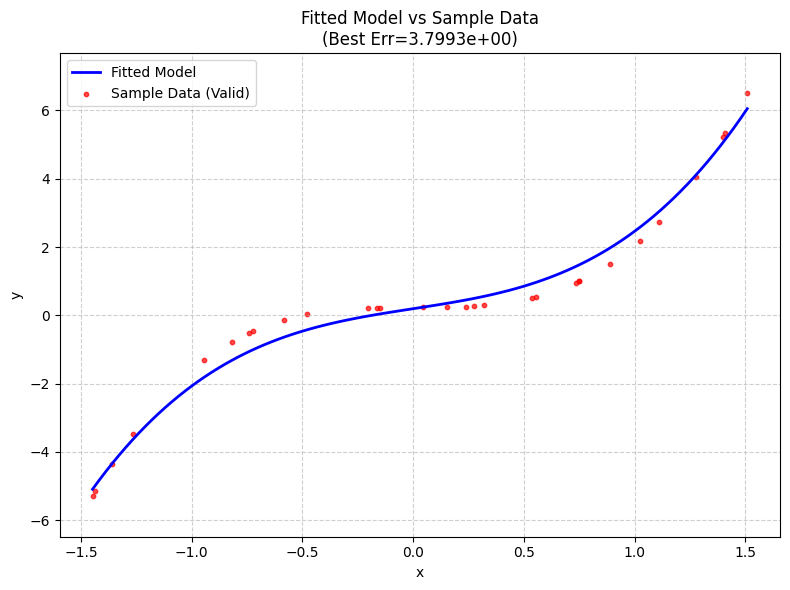

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 11.58 seconds.
Ground Truth Tokens:
[ 1  4  5 12  4 10  2  0  0  0  0  0]
Generated tokens: [ 1  4  5 12  4  5 13 10  4 10  2  2]
Decoded Ground Truth Expression: C x1 * C +
Decoded Expression: C x1 * C x1 / + C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 1.65 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=1.9314e-14
Original RPN: C x1 * C x1 / + C +


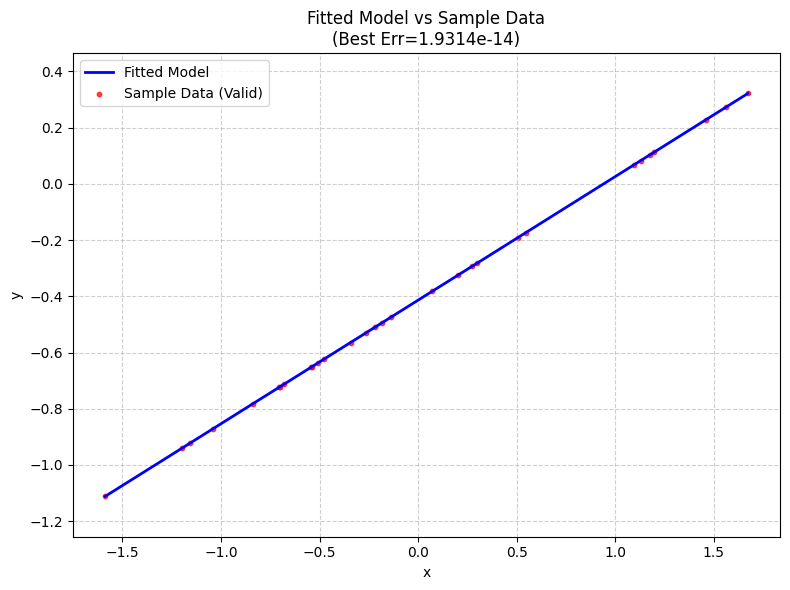

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 10.73 seconds.
Ground Truth Tokens:
[ 1  4  5 16 14 12  4 10  2  0  0  0]
Generated tokens: [ 1  4  5 16 14 12  4 10  2 10  2  2]
Decoded Ground Truth Expression: C x1 3 ** * C +
Decoded Expression: C x1 3 ** * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 1.16 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=4.0673e-08
Original RPN: C x1 3 ** * C +


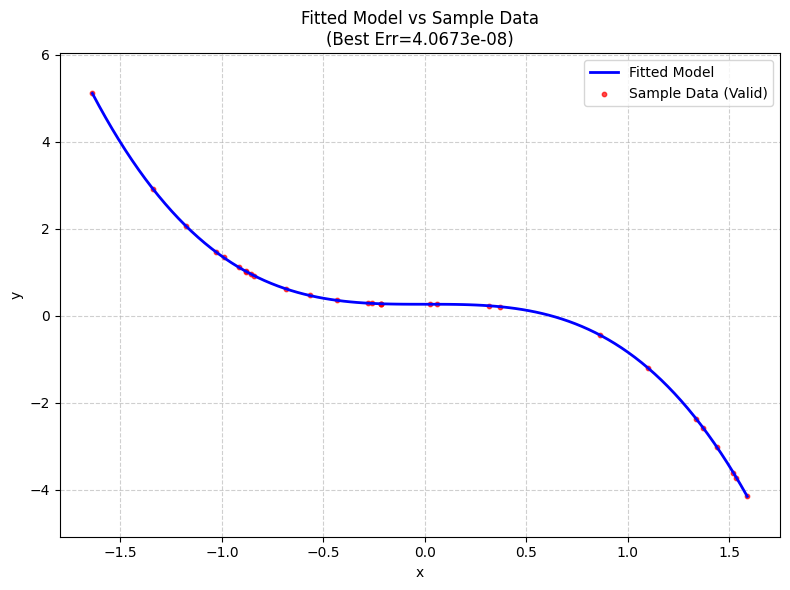

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 9.05 seconds.
Ground Truth Tokens:
[ 1  4  4  5 12  7 15 14 12  4 10  2]
Generated tokens: [ 1  4  4  5 12  4 10  6 12  4 10  2]
Decoded Ground Truth Expression: C C x1 * cos 2 ** * C +
Decoded Expression: C C x1 * C + sin * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 14.79 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=1.3363e-14
Original RPN: C C x1 * C + sin * C +


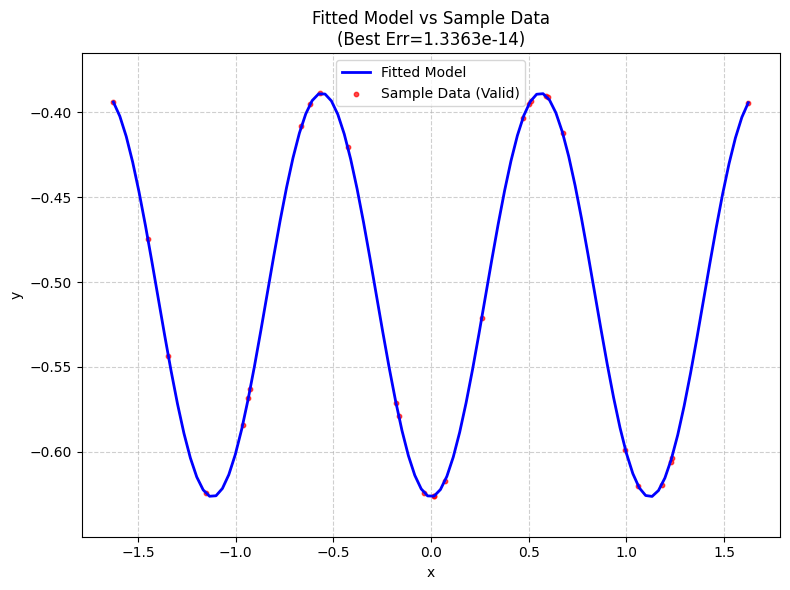

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 4.60 seconds.
Ground Truth Tokens:
[ 1  4  4  5 12  9 12  4 10  2  0  0]
Generated tokens: [ 1  4  4  5 12  4 10  6 12  4 10  2]
Decoded Ground Truth Expression: C C x1 * log * C +
Decoded Expression: C C x1 * C + sin * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 10.89 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=8.0370e-04
Original RPN: C C x1 * C + sin * C +


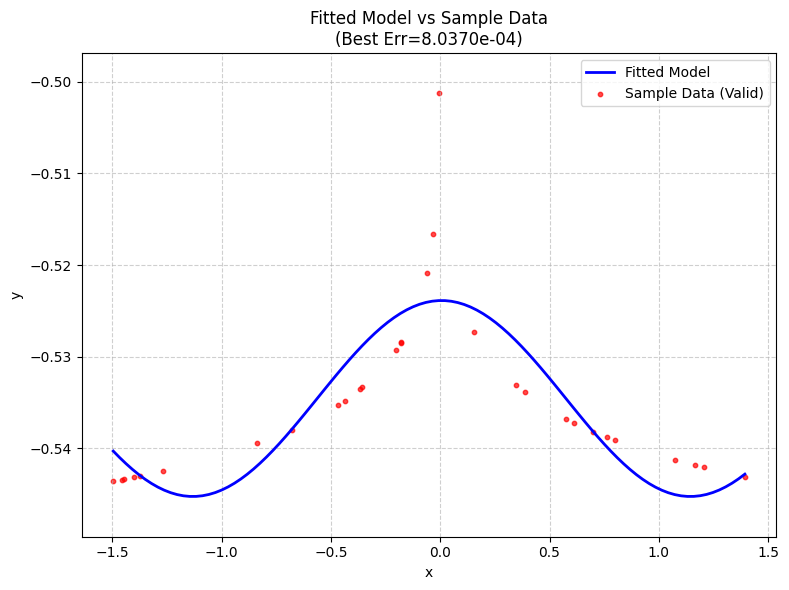

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 4.55 seconds.
Ground Truth Tokens:
[ 1  5  4 10  2  0  0  0  0  0  0  0]
Generated tokens: [ 1  4  5 12  4 10  2 10  4 10  2  2]
Decoded Ground Truth Expression: x1 C +
Decoded Expression: C x1 * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 0.98 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=2.6008e-14
Original RPN: C x1 * C +


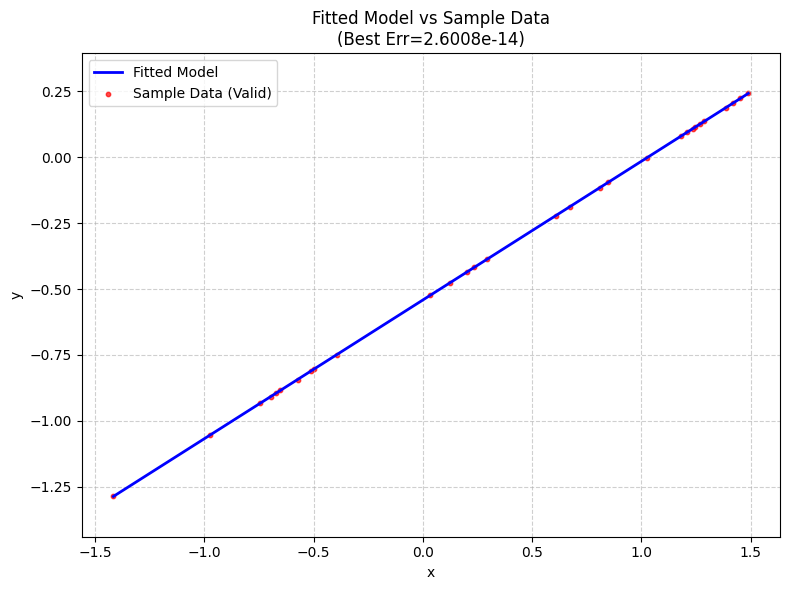

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 4.02 seconds.
Ground Truth Tokens:
[ 1  4  5 16 14 12  4 10  2  0  0  0]
Generated tokens: [ 1  4  5 16 14 12  5 10  4 10  2  2]
Decoded Ground Truth Expression: C x1 3 ** * C +
Decoded Expression: C x1 3 ** * x1 + C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 1.08 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=4.5149e+00
Original RPN: C x1 3 ** * x1 + C +


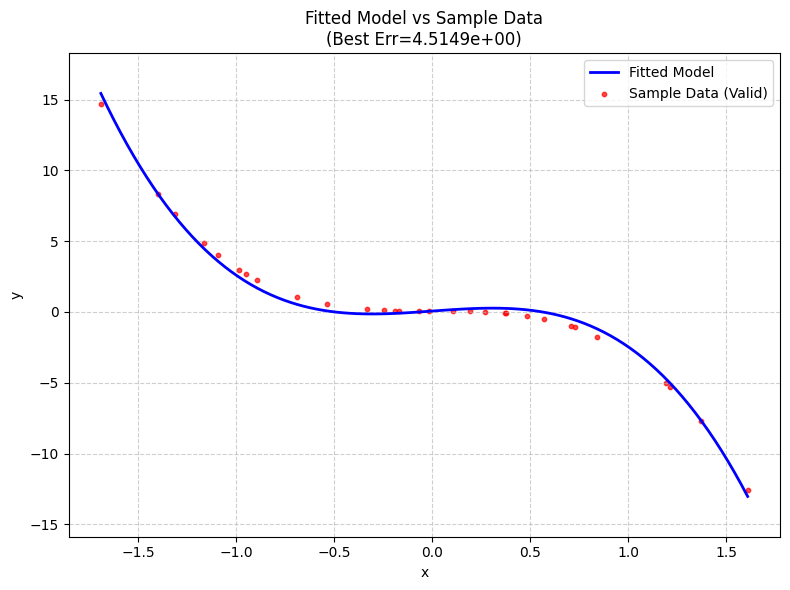

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 4.44 seconds.
Ground Truth Tokens:
[ 1  4  5 15 14 12  4 10  2  0  0  0]
Generated tokens: [ 1  4  5 15 14 12  4 10  2  4 10  2]
Decoded Ground Truth Expression: C x1 2 ** * C +
Decoded Expression: C x1 2 ** * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 1.14 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=3.6303e-08
Original RPN: C x1 2 ** * C +


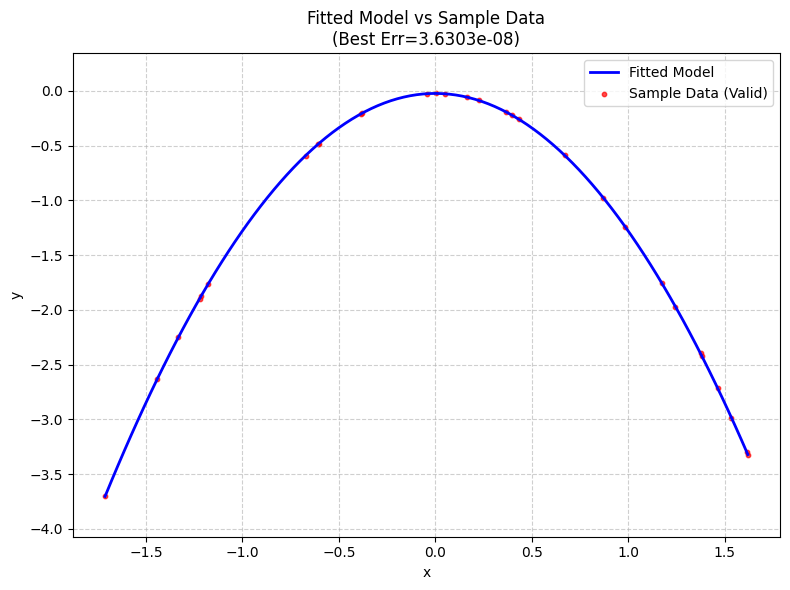

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 9.18 seconds.
Ground Truth Tokens:
[ 1  4  5 12  4 10  2  0  0  0  0  0]
Generated tokens: [ 1  4  5 12  4 10  2 10  4 10  2  2]
Decoded Ground Truth Expression: C x1 * C +
Decoded Expression: C x1 * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 1.07 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=2.8939e-14
Original RPN: C x1 * C +


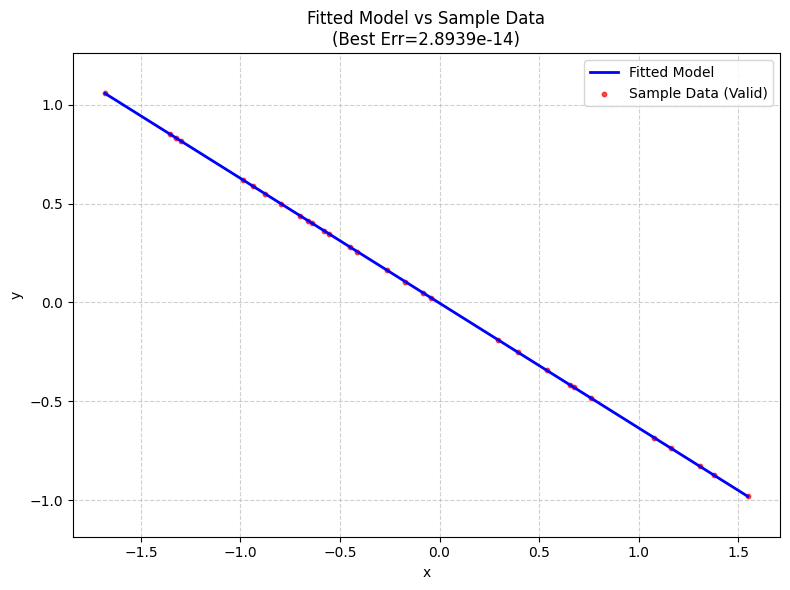

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 4.52 seconds.
Ground Truth Tokens:
[ 1  4  4  5 12  9 12  4 10  2  0  0]
Generated tokens: [ 1  4  4  5 12  9 12  4 10  2 10  2]
Decoded Ground Truth Expression: C C x1 * log * C +
Decoded Expression: C C x1 * log * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 3.72 seconds.
Fit Status: Success (57/64 LBFGS runs OK): Best Err=5.4726e-10
Original RPN: C C x1 * log * C +


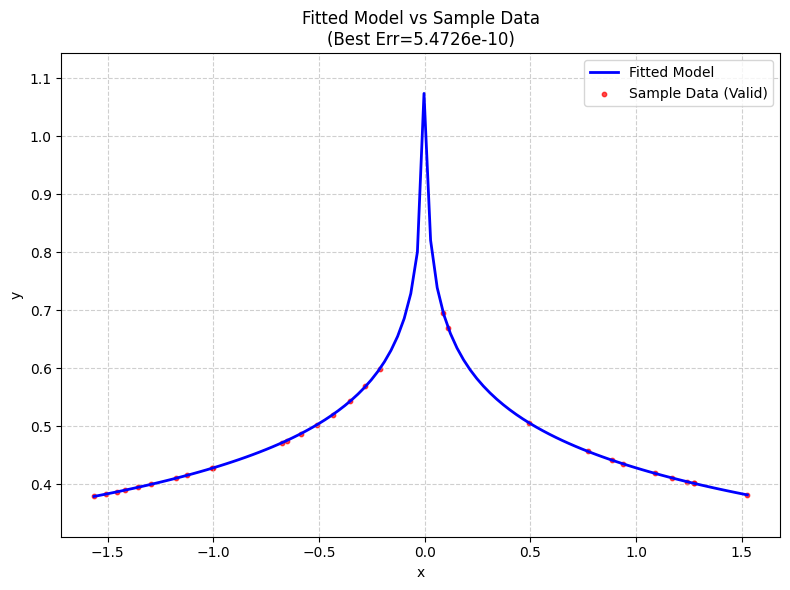

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 5.37 seconds.
Ground Truth Tokens:
[ 1  4  4  5 12  4 10  6 12  4 10  2]
Generated tokens: [ 1  4  4  5 12  4 10  6 12  4 10  2]
Decoded Ground Truth Expression: C C x1 * C + sin * C +
Decoded Expression: C C x1 * C + sin * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 36.19 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=6.4969e-14
Original RPN: C C x1 * C + sin * C +


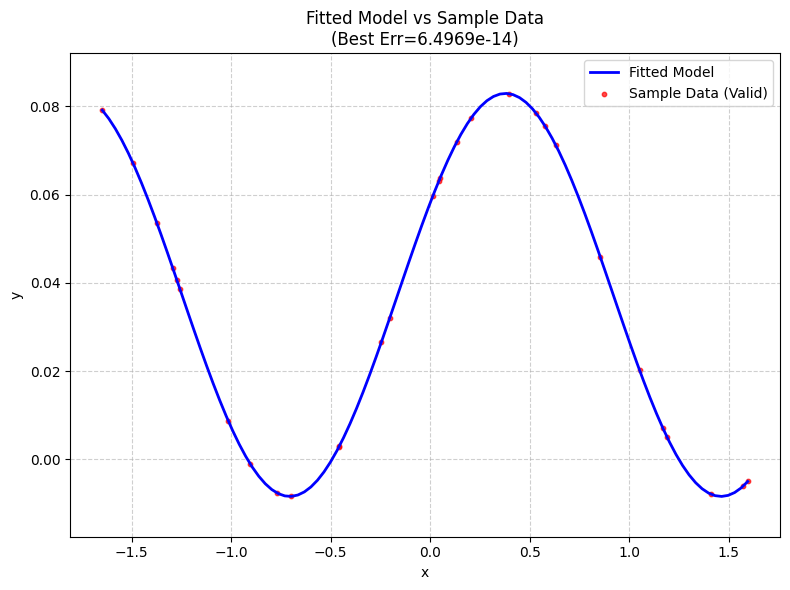

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 8.33 seconds.
Ground Truth Tokens:
[ 1  4  4  5 12  8 12  4 10  2  0  0]
Generated tokens: [ 1  4  4  5 12  8 12  4 10  2 10  2]
Decoded Ground Truth Expression: C C x1 * exp * C +
Decoded Expression: C C x1 * exp * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 6.03 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=4.6255e-13
Original RPN: C C x1 * exp * C +


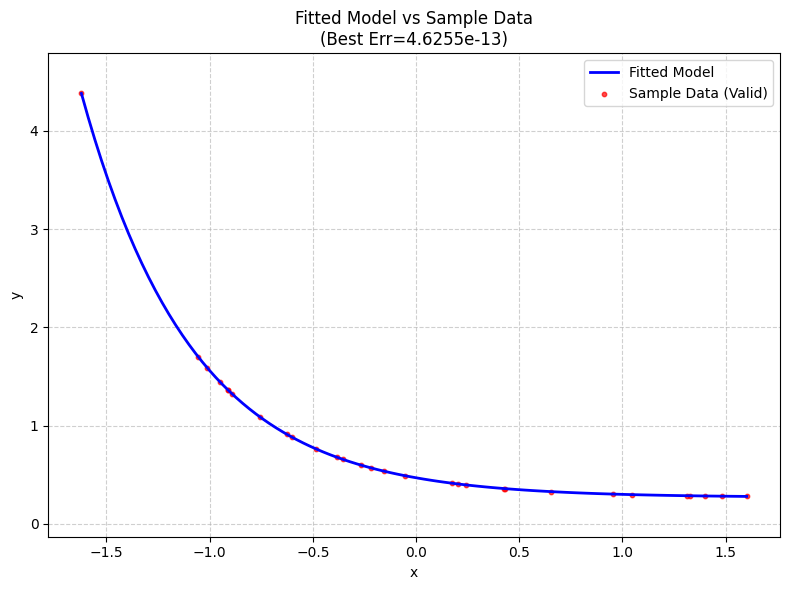

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 6.43 seconds.
Ground Truth Tokens:
[ 1  4  4  5 12  8 12  4 10  2  0  0]
Generated tokens: [ 1  4  4  5 12  4 10  9 12  4 10  2]
Decoded Ground Truth Expression: C C x1 * exp * C +
Decoded Expression: C C x1 * C + log * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 10.15 seconds.
Fit Status: Success (63/64 LBFGS runs OK): Best Err=1.6483e-04
Original RPN: C C x1 * C + log * C +


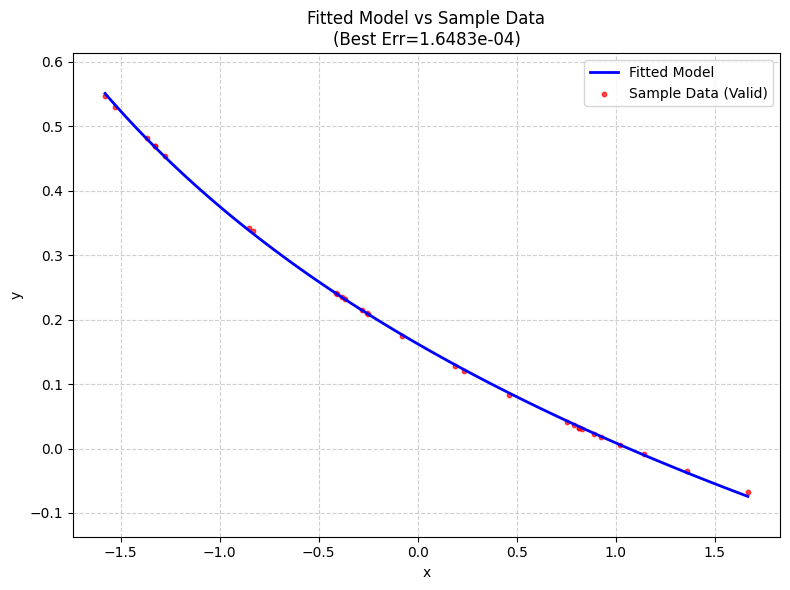

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 5.84 seconds.
Ground Truth Tokens:
[ 1  4  4  5 12  8 12  4 10  2  0  0]
Generated tokens: [ 1  4  4  5 12  8 12  4 10  2 10  2]
Decoded Ground Truth Expression: C C x1 * exp * C +
Decoded Expression: C C x1 * exp * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 10.04 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=4.7634e-14
Original RPN: C C x1 * exp * C +


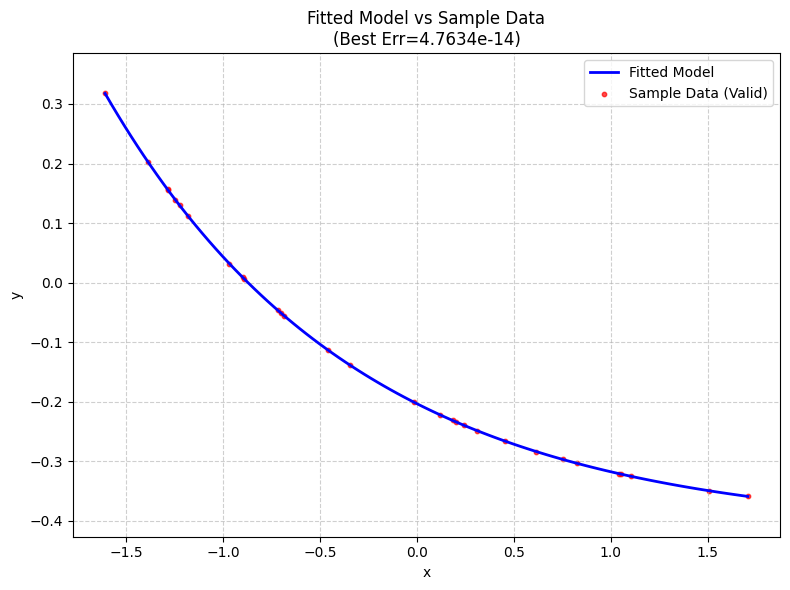

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 5.09 seconds.
Ground Truth Tokens:
[ 1  4  4  5 12  6 12  4 10  2  0  0]
Generated tokens: [ 1  4  4  5 12  4 10  9 12  4 10  2]
Decoded Ground Truth Expression: C C x1 * sin * C +
Decoded Expression: C C x1 * C + log * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 10.18 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=4.2586e-03
Original RPN: C C x1 * C + log * C +


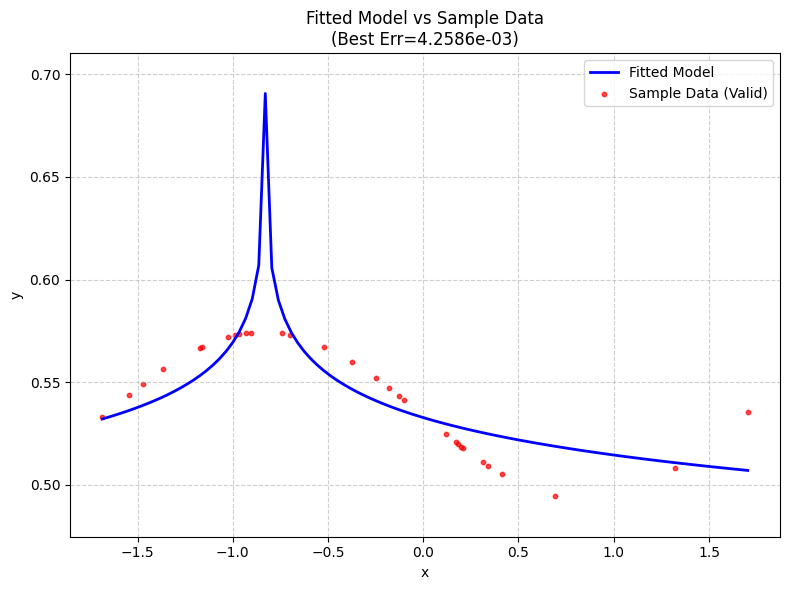

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 10.20 seconds.
Ground Truth Tokens:
[ 1  4  5 12  4 10  2  0  0  0  0  0]
Generated tokens: [ 1  4  5 12  4  5 13 10  4 10  2  2]
Decoded Ground Truth Expression: C x1 * C +
Decoded Expression: C x1 * C x1 / + C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 2.43 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=1.7839e-13
Original RPN: C x1 * C x1 / + C +


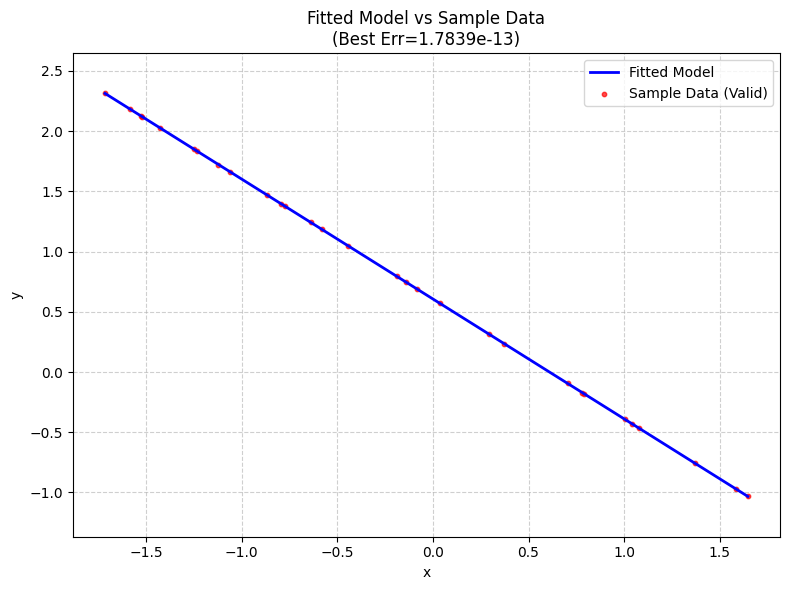

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 6.62 seconds.
Ground Truth Tokens:
[1 4 2 0 0 0 0 0 0 0 0 0]
Generated tokens: [ 1  4  4  5 12  9 12  4 10  2 10  2]
Decoded Ground Truth Expression: C
Decoded Expression: C C x1 * log * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 7.80 seconds.
Fit Status: Success (58/64 LBFGS runs OK): Best Err=3.4213e-16
Original RPN: C C x1 * log * C +


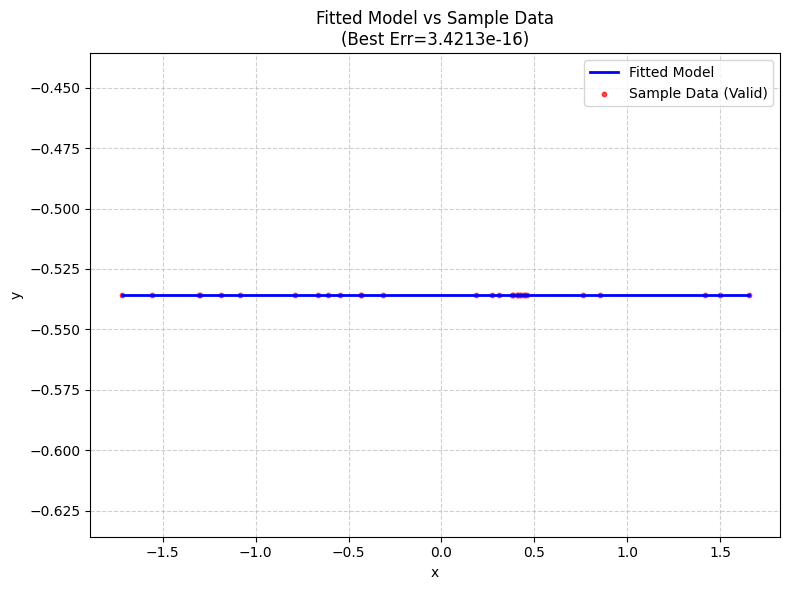

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 12.04 seconds.
Ground Truth Tokens:
[ 1  4  4  5 12  9 12  4 10  2  0  0]
Generated tokens: [ 1  4  4  5 12  9 12  4 10  2 10  2]
Decoded Ground Truth Expression: C C x1 * log * C +
Decoded Expression: C C x1 * log * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 5.86 seconds.
Fit Status: Success (60/64 LBFGS runs OK): Best Err=3.6467e-09
Original RPN: C C x1 * log * C +


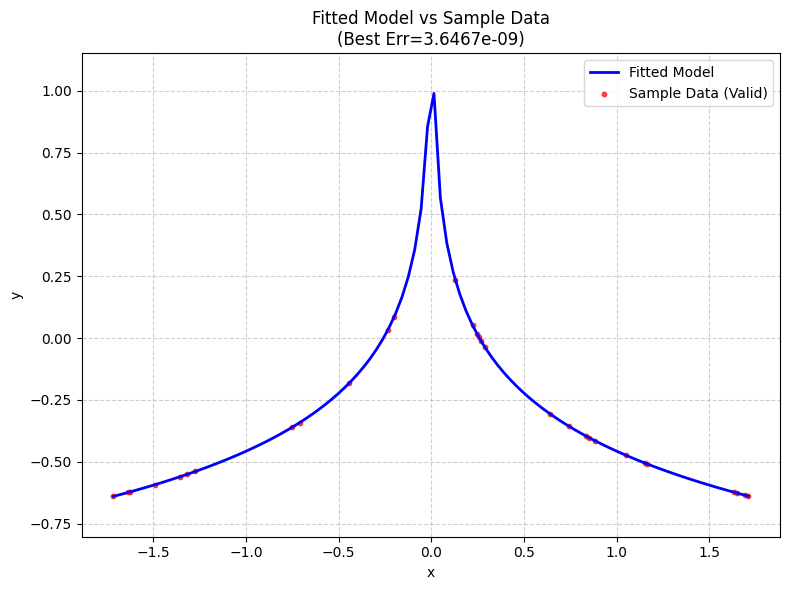

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 5.39 seconds.
Ground Truth Tokens:
[ 1  4  4  5 12  8 12  4 10  2  0  0]
Generated tokens: [ 1  4  4  5 12  8 12  4 10  2 10  2]
Decoded Ground Truth Expression: C C x1 * exp * C +
Decoded Expression: C C x1 * exp * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 6.54 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=1.7620e-12
Original RPN: C C x1 * exp * C +


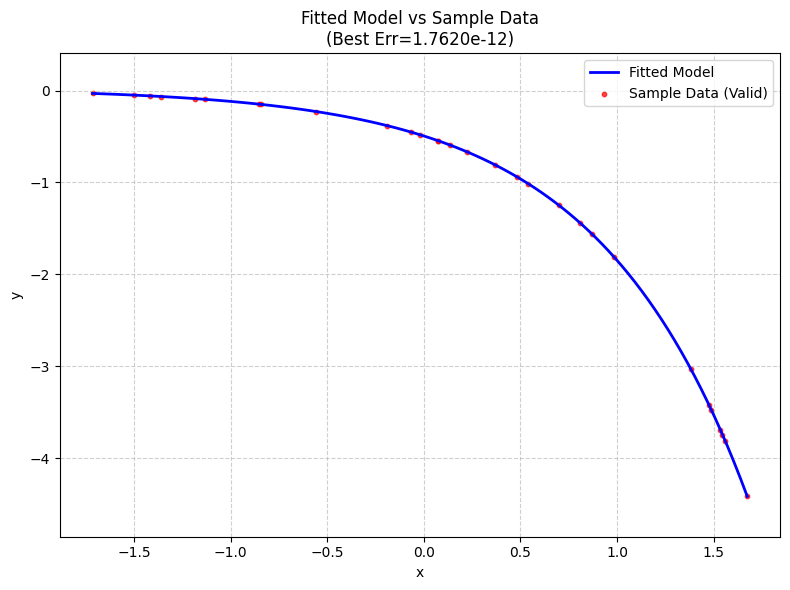

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 8.11 seconds.
Ground Truth Tokens:
[ 1  4  5 12  4 10  2  0  0  0  0  0]
Generated tokens: [ 1  4  5 12  4  5 13 10  4 10  2  2]
Decoded Ground Truth Expression: C x1 * C +
Decoded Expression: C x1 * C x1 / + C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 1.90 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=8.1307e-14
Original RPN: C x1 * C x1 / + C +


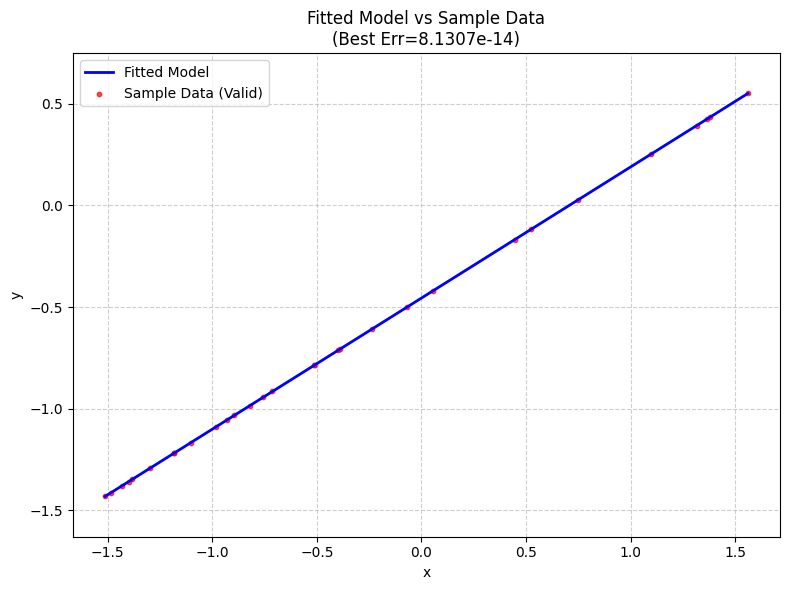

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 10.26 seconds.
Ground Truth Tokens:
[ 1  4  5 12  4 10  2  0  0  0  0  0]
Generated tokens: [ 1  4  5 12  4 10  2 10  4 10  2  2]
Decoded Ground Truth Expression: C x1 * C +
Decoded Expression: C x1 * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 1.06 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=5.1745e-14
Original RPN: C x1 * C +


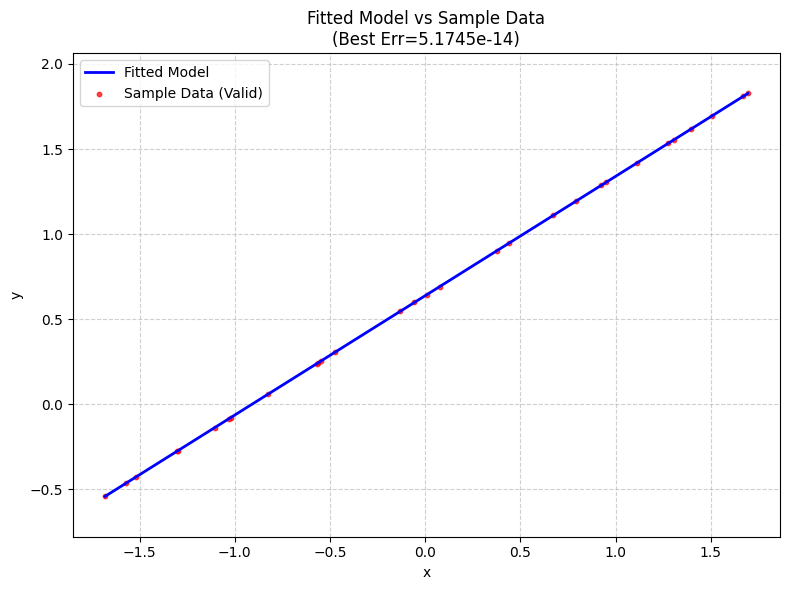

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 6.91 seconds.
Ground Truth Tokens:
[ 1  4  4  5 12  9 12  4 10  2  0  0]
Generated tokens: [ 1  4  4  5 15 14 12  9 12  4 10  2]
Decoded Ground Truth Expression: C C x1 * log * C +
Decoded Expression: C C x1 2 ** * log * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 5.13 seconds.
Fit Status: Success (60/64 LBFGS runs OK): Best Err=1.0884e-10
Original RPN: C C x1 2 ** * log * C +


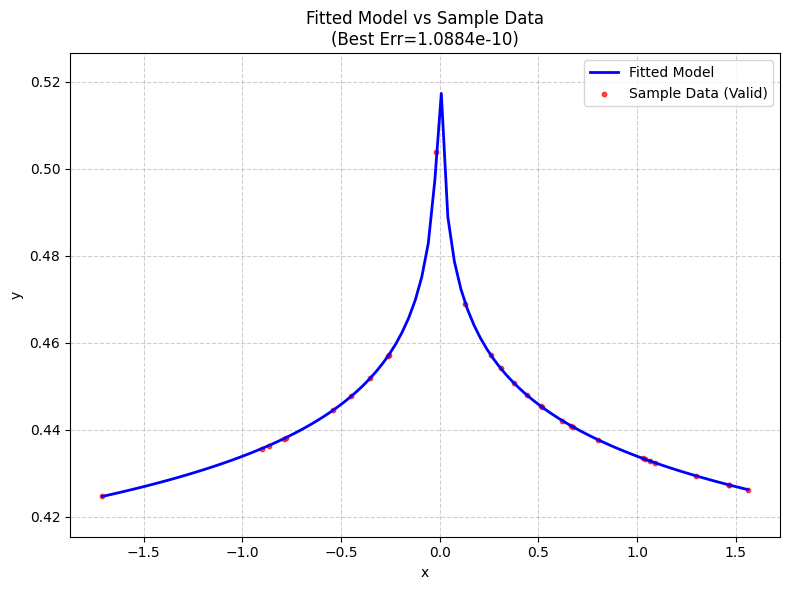

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 5.82 seconds.
Ground Truth Tokens:
[1 4 2 0 0 0 0 0 0 0 0 0]
Generated tokens: [ 1  4  4  5 12  4 10  7 12  4 10  2]
Decoded Ground Truth Expression: C
Decoded Expression: C C x1 * C + cos * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 2.86 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=2.9870e-16
Original RPN: C C x1 * C + cos * C +


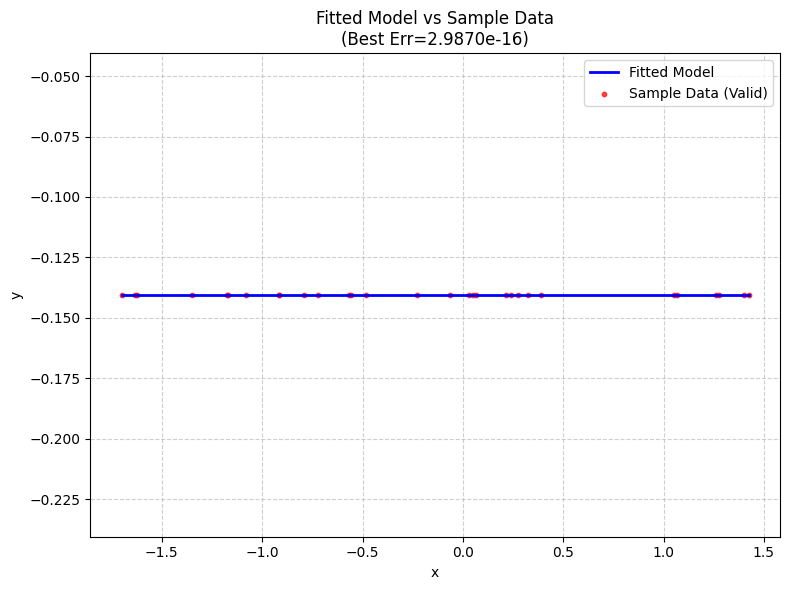

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 7.20 seconds.
Ground Truth Tokens:
[1 4 2 0 0 0 0 0 0 0 0 0]
Generated tokens: [ 1  4  4  5 12  9 12  4 10  2 10  2]
Decoded Ground Truth Expression: C
Decoded Expression: C C x1 * log * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 6.72 seconds.
Fit Status: Success (58/64 LBFGS runs OK): Best Err=3.1869e-16
Original RPN: C C x1 * log * C +


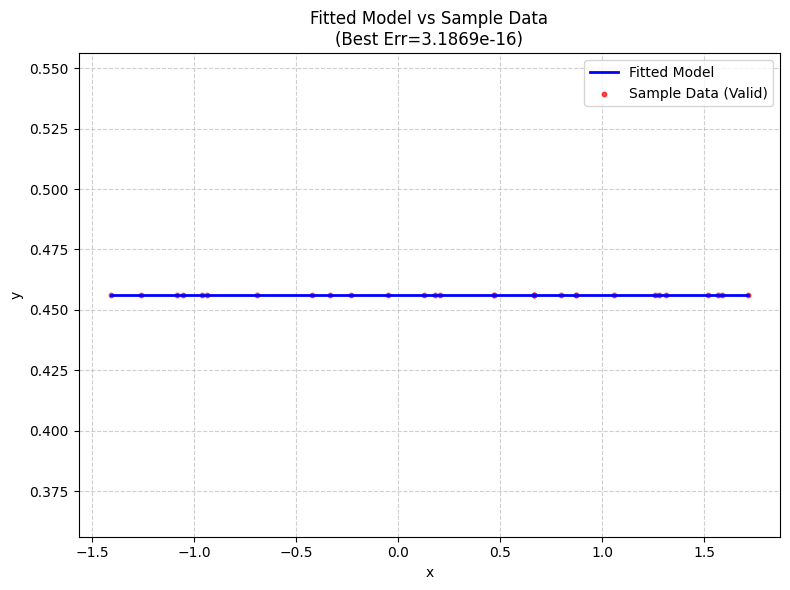

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 10.27 seconds.
Ground Truth Tokens:
[ 1  4  4  5 12  9 12  4 10  2  0  0]
Generated tokens: [ 1  4  4  5 13  9 12  4 10  2 10  2]
Decoded Ground Truth Expression: C C x1 * log * C +
Decoded Expression: C C x1 / log * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 2.43 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=1.3119e-07
Original RPN: C C x1 / log * C +


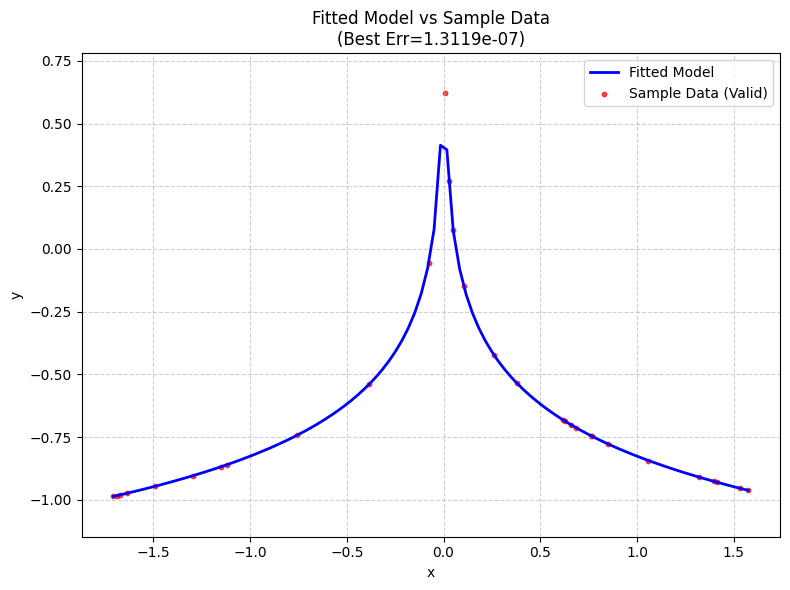

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 5.31 seconds.
Ground Truth Tokens:
[ 1  4  5 12  4 10  2  0  0  0  0  0]
Generated tokens: [ 1  4  5 12  4  5 13 10  4 10  2  2]
Decoded Ground Truth Expression: C x1 * C +
Decoded Expression: C x1 * C x1 / + C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 1.71 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=5.7446e-14
Original RPN: C x1 * C x1 / + C +


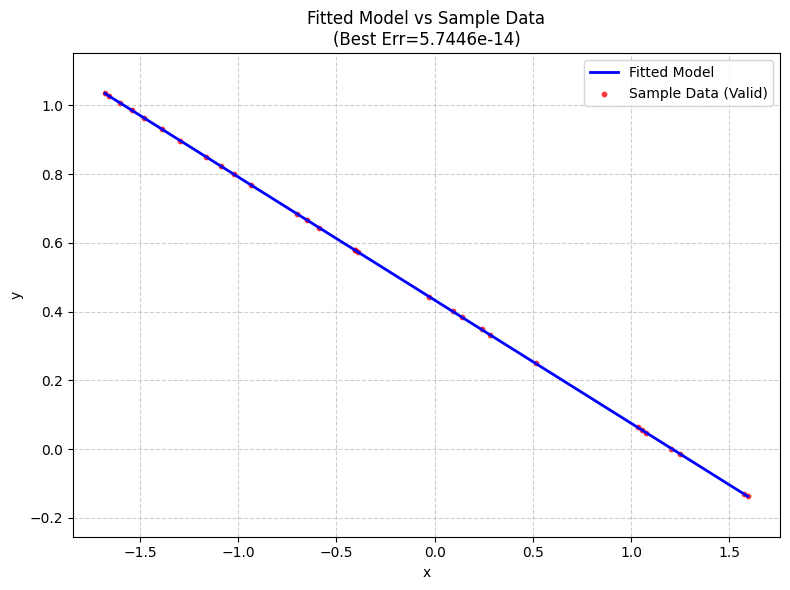

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 5.97 seconds.
Ground Truth Tokens:
[ 1  4  4  5 12  4 10  7 12  4 10  2]
Generated tokens: [ 1  4  4  5 12  4 10  6 12  4 10  2]
Decoded Ground Truth Expression: C C x1 * C + cos * C +
Decoded Expression: C C x1 * C + sin * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 26.06 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=1.1368e-14
Original RPN: C C x1 * C + sin * C +


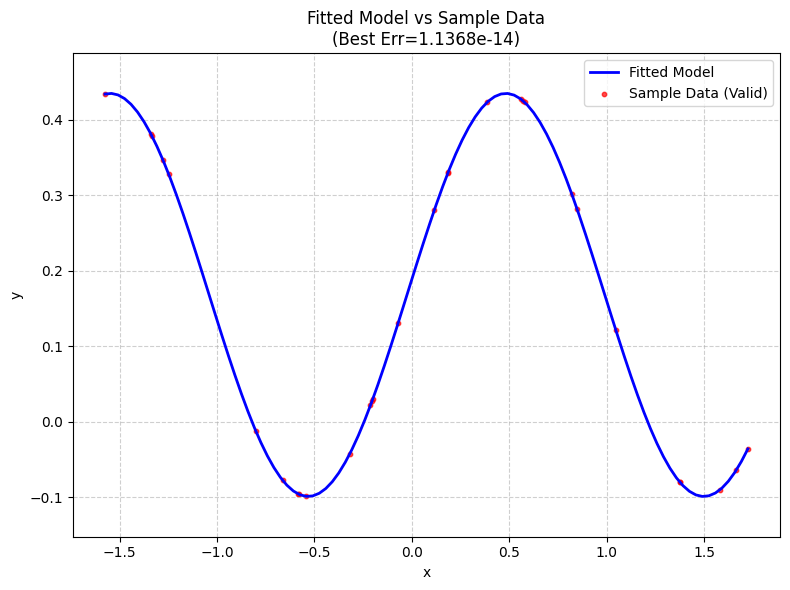

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 11.46 seconds.
Ground Truth Tokens:
[ 1  4  5 12  4 10  2  0  0  0  0  0]
Generated tokens: [ 1  4  5 12  4  5 13 10  4 10  2  2]
Decoded Ground Truth Expression: C x1 * C +
Decoded Expression: C x1 * C x1 / + C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 2.46 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=3.0167e-14
Original RPN: C x1 * C x1 / + C +


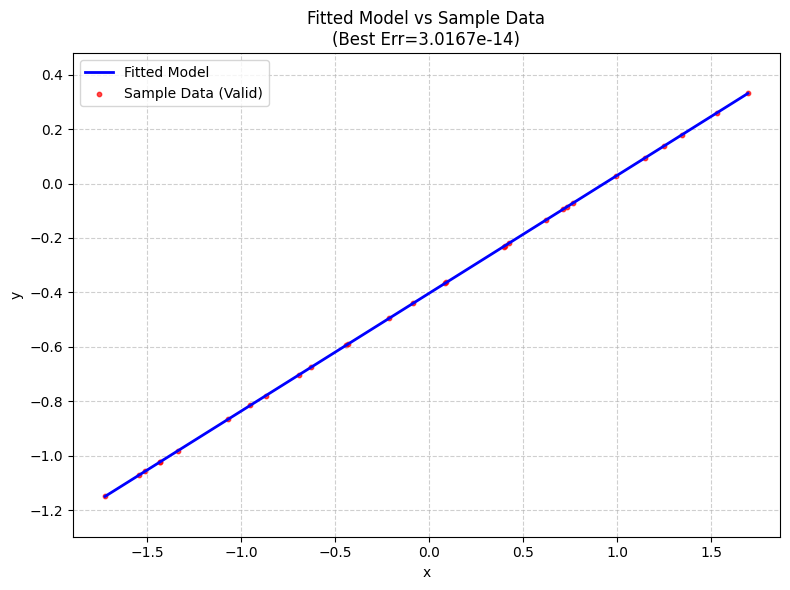

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 6.67 seconds.
Ground Truth Tokens:
[ 1  4  5 12  4 10  2  0  0  0  0  0]
Generated tokens: [ 1  4  5 12  4 10  2 10  4 10  2  2]
Decoded Ground Truth Expression: C x1 * C +
Decoded Expression: C x1 * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 0.97 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=1.1203e-14
Original RPN: C x1 * C +


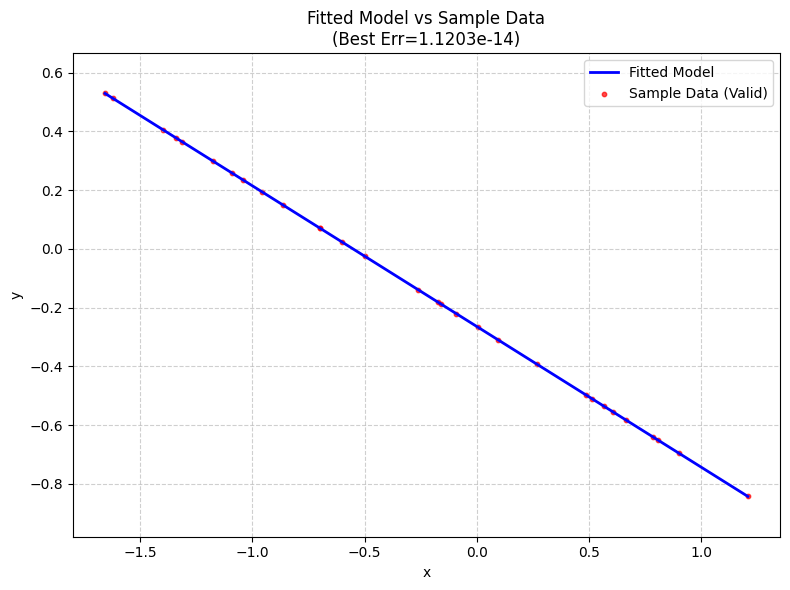

Generating sequence for item (Condition shape: torch.Size([1, 30, 2]))...
Sampling timestep 1/1000      
Sampling complete.
Generation took 6.62 seconds.
Ground Truth Tokens:
[ 1  4  4  5 12  4 10  7 12  4 10  2]
Generated tokens: [ 1  4  4  5 12  4 10  7 12  4 10  2]
Decoded Ground Truth Expression: C C x1 * C + cos * C +
Decoded Expression: C C x1 * C + cos * C +
Starting 64 L-BFGS-B runs using up to 32 workers...
Parallel L-BFGS-B finished in 33.35 seconds.
Fit Status: Success (64/64 LBFGS runs OK): Best Err=2.0677e-14
Original RPN: C C x1 * C + cos * C +


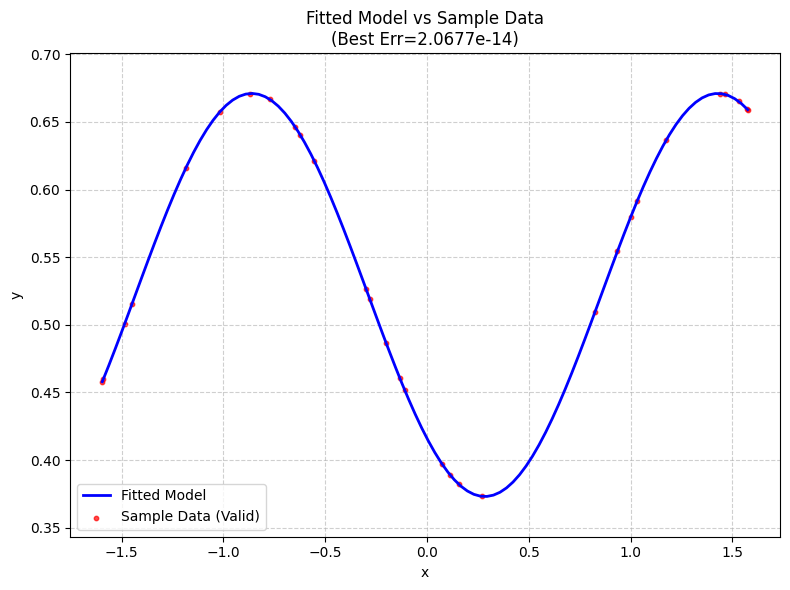

In [8]:
#item_index_to_generate = 0 # Or 117, or any other valid index
import pickle

for item_index_to_generate in range(24, 54):

    data_item_to_generate = test_data[item_index_to_generate]

    # 4. Call the generation function
    generated_tokens = generate_tokens(
        data_item=data_item_to_generate,
        model=loaded_model,
        diffusion_helper=diffusion_sampler_gen,
        x_mean=x_mean_gen,
        x_std=x_std_gen,
        y_mean=y_mean_gen,
        y_std=y_std_gen,
        device=DEVICE,
        seq_len=SEQ_LEN,
        n_points=N_POINTS,
        xy_dim=XY_DIM
    )

    if 'token_ids' in data_item_to_generate:
                    true_tokens = np.array(data_item_to_generate['token_ids'])
                    print(f"Ground Truth Tokens:\n{true_tokens}")

    print(f"Generated tokens: {generated_tokens}")

    tokenizer = MathTokenizer()
    
    # Discard all tokens after the first occurrence of 2
    if 2 in generated_tokens:
        generated_tokens = generated_tokens[:np.where(generated_tokens == 2)[0][0] + 1]

    # Decode the generated tokens
    decoded_expression = tokenizer.decode(generated_tokens)
    decoded_ground_truth = tokenizer.decode(true_tokens)
    print(f"Decoded Ground Truth Expression: {decoded_ground_truth}")

    print(f"Decoded Expression: {decoded_expression}")

    #Un-Normalize the data
    with open('normalization_params.pkl', 'wb') as f:
        pickle.dump({'x_mean': x_mean, 'x_std': x_std, 'y_mean': y_mean, 'y_std': y_std}, f)
        
    # Split the 30x2 array into two 30x1 arrays and save as keys "X" and "Y"
    data_item_to_generate["X"] = [coord[0]*x_std+x_mean for coord in data_item_to_generate["X_Y_combined"]]
    data_item_to_generate["Y"] = [coord[1]*y_std+y_mean for coord in data_item_to_generate["X_Y_combined"]]

    # Write the decoded expression to the "RPN" key
    data_item_to_generate["RPN"] = decoded_expression

    process_and_plot(data_item_to_generate)